In [566]:
#!/usr/bin/python3

In [600]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
from collections import deque
from statistics import mean, stdev
from PIL import Image  
import PIL
import os

In [632]:
Debug = False
Print = True
OUT_DIR = "my_output/"

In [635]:
def save_image(image, path):
    full_path = OUT_DIR+path
    
    pos1 = full_path.rfind('/')
    dir_path = full_path[:pos1]
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    with open(full_path, 'wb') as temp_file:
        pass

    #im = Image.fromarray(image)
    #im.save(full_path, cmap=cm.gray)
    plt.imsave(full_path, image, cmap=plt.cm.gray)

In [569]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

def get_calibration():
    images = glob.glob('camera_cal/calibration*.jpg')
    img_size = None
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
        img_size = (image.shape[1], image.shape[0])
    # ret, mtx, dist, rvecs, tvecs
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

            

In [570]:
calibration_data = get_calibration()
def get_undistorted_image(image):
    return cv2.undistort(image, calibration_data[1], calibration_data[2])

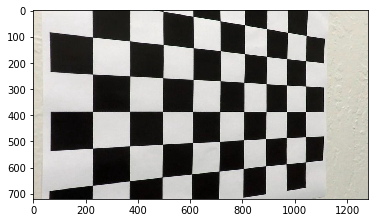

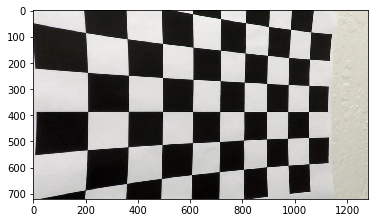

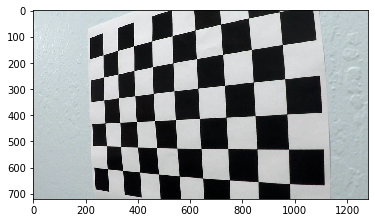

In [636]:
def check_calibration(limit=1):
    images = glob.glob('camera_cal/calibration*.jpg')
    checked = 0
    for image_path in images:
        image = cv2.imread(image_path)
        plt.figure()
        plt.imshow(image)
        checked+=1
        if checked > limit:
            break
        dst = get_undistorted_image(image)
        plt.figure()
        plt.imshow(dst)
        
        if Print:
            save_image(dst, image_path)
check_calibration(1)

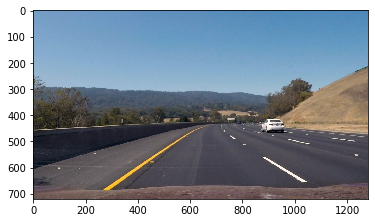

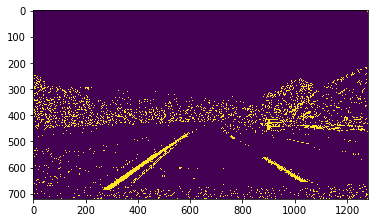

In [621]:
def get_binary_edges(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    return my_get_binary_edges(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary | sxbinary
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

def my_get_binary_edges(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    BYTE = 255
    TH = 100
    low = BYTE-40
    binary_output =  np.zeros_like(R)
    binary_output[((R>BYTE-TH) & (G>BYTE-TH) & (B<130)) | ((R>low) & (G>low) & (B>low))] = 1
    BY_COLOR = binary_output
    
    #print(type(BY_COLOR))
    
    #return BY_COLOR
    
    
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    
#     channel = hls[:,:,2]
#     sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize = 9)
#     sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize = 9)    
#     sobelx = np.absolute(sobelx)
#     sobely = np.absolute(sobely)    
#     sobel = np.sqrt( sobelx**2 + sobely**2)
#     thresh=(10, 1000)
#     binary_output =  np.zeros_like(channel)
#     binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
#     return binary_output
    
    
    channel = hls[:,:,1]
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize = 7)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize = 7)  
    sobel = np.sqrt( sobelx**2 + sobely**2)
    threshT=(4000, 10000000)
    binary_output_L =  np.zeros_like(channel)
    binary_output_L[(sobel >= threshT[0]) & (sobel <= threshT[1])] = 1
    #return binary_output_L
    
    thresh=(np.pi * 0.18, np.pi * 0.33)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))   
    binary_output_dir =  np.zeros_like(channel)
    binary_output_dir[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1]) &
                     (sobel >= threshT[0]) & (sobel <= threshT[1])] = 1
    
    #return binary_output_dir
    binary_output_dir[BY_COLOR>=1] = 1
    #print(binary_output_dir.shape)
    #binary_output_dir = [binary_output_dir, binary_output_dir, binary_output_dir]
    #print(binary_output_dir.shape)
    return binary_output_dir
    
    #return (binary_output_L) & (binary_output_dir)
    
    #print(binary_output_dir.shape)
    #print(BY_COLOR.shape)
    
    return  binary_output_dir | BY_COLOR
    scaled_sobel = np.uint8(255*absgraddir/np.max(absgraddir))
    
    return scaled_sobel
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary | sxbinary
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

LDebug = True
if LDebug:
    images = glob.glob('test_images/*.jpg')
    for image_path in images:
        if image_path != "test_images/test3.jpg":
            continue
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(image)

        image = my_get_binary_edges(image)
        plt.figure()
        plt.imshow(image)

In [573]:
def update_perspective_data(image):
    global M, Minv
    w = image.shape[1]
    h = image.shape[0]
    if M is None:
        mul = 0.635
        src = np.float32([
            [w*0.15, h],
            [w*0.5-w*0.08, h*mul],
            [w*0.5+w*0.08, h*mul],
            [w-w*0.15, h]
        ])
        
        dst = np.float32([
            [w*0.1, h],
            [w*0.1, 0],
            [w-w*0.1, 0],
            [w-w*0.1, h]
        ])
        
        #print(src, dst)
        
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
    
def get_perspective(image, use_inv = False):
    w = image.shape[1]
    h = image.shape[0]
    update_perspective_data(image)
    warped = cv2.warpPerspective(image, Minv if use_inv else M, (w,h), flags=cv2.INTER_LINEAR)
    return warped

In [574]:
left_curvature_list = None
right_curvature_list = None
vehicle_position_list = None
l_poly, r_poly = None, None
Debug = None
M, Minv = None, None
def new_test_case(debug = False):
    global left_curvature_list, right_curvature_list, vehicle_position_list, l_poly, r_poly, Debug
    global M, Minv
    left_curvature_list, right_curvature_list = deque(maxlen=20), deque(maxlen=20)
    vehicle_position_list = deque(maxlen=20)
    l_poly, r_poly = None, None
    M, Minv = None, None
    if debug:
        Debug = True
    else:
        Debug = False

In [575]:
def find_lane_pixels(binary_warped):
    global Debug
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*0.50):,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint_l = np.int(int(histogram.shape[0]*0.4))
    leftx_base = np.argmax(histogram[:midpoint_l])
    midpoint_r = np.int(int(histogram.shape[0]*0.6))
    rightx_base = np.argmax(histogram[midpoint_r:]) + midpoint_r

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        w = binary_warped.shape[1]
        win_xleft_low = leftx_current - margin
        win_xleft_high = min(leftx_current + margin, w//2)
        win_xright_low = max(rightx_current - margin, w//2)
        win_xright_high = rightx_current + margin
        
        if Debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
                
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        #print(len(good_left_inds), len(good_right_inds))
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #print(len(good_left_inds) , 0.05 * window_height * margin)
        #if len(good_left_inds) > 0.05 * window_height * margin:
        #leftx_current = int(np.mean(nonzerox[good_left_inds]))
        #if len(good_right_inds) > 0.05 * window_height * margin:
        #rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #print(len(lefty), len(leftx))
    #print(len(righty), len(rightx))
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #print(len(ploty))
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    

    if Debug:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    
    #print(len(left_fitx))

    return out_img, left_fit, right_fit, len(leftx), len(rightx)

In [644]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    global Debug
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if Debug:
        print(right_fit, len(nonzerox), len(nonzeroy))

    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    w = binary_warped.shape[1]
    h = binary_warped.shape[0]
    left_lane_inds = ((nonzeroy<=h*0.95) &(nonzerox<=w//2) & (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzeroy<=h*0.95) &(nonzerox>=w//2) &(nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if Debug:
        print(len(leftx), len(lefty), "L")
        print(len(rightx), len(righty), "R")

    # Fit new polynomials
    left_fitx, right_fitx, ploty, new_left_fit, new_right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if Print:
        save_image(out_img, "per_lane_pixels.jpg")

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    lane_pts = np.hstack((left_line_window2, right_line_window1))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255, 0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 0, 255))
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0, 255, 0))
    
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if Debug:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='red')
        plt.plot(right_fitx, ploty, color='red')
        ## End visualization steps ##
    
    return window_img, new_left_fit, new_right_fit, len(leftx), len(rightx)

In [577]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 20.0/720 # meters per pixel in y dimension
    xm_per_pix = 4.0/700 # meters per pixel in x dimension
    
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    #rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
    #                                for y in ploty])

    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty, rightx, 2)
        
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    y = np.max(ploty*ym_per_pix)
    A = left_fit_cr[0]
    B = left_fit_cr[1]
    C = left_fit_cr[2]
    left_curverad =  np.sqrt((1+(2*A*y+B)**2)**3)/(2*np.abs(A))
    
    A = right_fit_cr[0]
    B = right_fit_cr[1]
    C = right_fit_cr[2]
    right_curverad =  np.sqrt((1+(2*A*y+B)**2)**3)/(2*np.abs(A))
    
    return left_curverad, right_curverad

In [578]:
def print_car_position(image, left_fit, right_fit):
    y = image.shape[0]
    leftP = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    rightP = right_fit[0]*y**2 + right_fit[1]*y+right_fit[2]
    pixel_len=3.7/(rightP-leftP)
    mid = (leftP + rightP)*0.5
    image_mid = image.shape[1] * 0.5
    
    dst = int(image_mid - mid) * pixel_len
    vehicle_position_list.append(dst)
    dst = mean(vehicle_position_list)
    text = "Vehicle is {:.2f} {} of center".format(abs(dst), "Left" if dst<0 else "Right")
    cv2.putText(image, text, (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    

In [642]:
def solution(image_tmp):
    global l_poly, r_poly
    image = np.copy(image_tmp)
    image = get_undistorted_image(image)
    if Debug:
        plt.figure()
        plt.imshow(image)
    undist_image = np.copy(image)
    image = get_binary_edges(image)
    
    if Print:
        save_image(image, "edges.jpg")
    
    #print("E",image.shape)
    #print("SAV", undist_image.shape)
    
    if Debug:
        plt.figure()
        plt.imshow(image)

    #return image
    image = get_perspective(image)
    
    if Print:
        save_image(image, "perspective_edges.jpg")
    
    if Debug:
        plt.figure(figsize = (20,40))
        plt.imshow(image)
    
    image_print, l_poly_fit, r_poly_fit, cnt_l, cnt_r = fit_polynomial(np.copy(image))
    if Debug:
        plt.imshow(image_print)
            
    if l_poly is None:
        l_poly = l_poly_fit
        r_poly = r_poly_fit
        
    if Debug:
        print(cnt_l, cnt_r)
    
    have_l, have_r = 0, 0
    image, l_poly, r_poly, have_l, have_r = search_around_poly(np.copy(image), l_poly, r_poly)
    
    if Debug:
        print("Brute", cnt_r, "Refit: ", have_r)
    
    if cnt_l > have_l:
        l_poly = l_poly_fit
    if cnt_r > have_r:
        r_poly = r_poly_fit
    
    if Debug:
        plt.imshow(image)
        
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_curv, right_curv = measure_curvature_real(ploty, l_poly, r_poly)
    left_curvature_list.append(left_curv)
    right_curvature_list.append(right_curv)
    text = "Curvature: Left {:.1f}, Right {:.1f}".format(mean(left_curvature_list), mean(right_curvature_list))
    if Debug:
        print(text)
    
    
    if Debug:
        plt.figure()
        plt.imshow(image)
    
        
    image = get_perspective(image, True)
    
    if Debug:
        plt.figure()
        plt.imshow(image)
        
    image = cv2.addWeighted(undist_image, 1, image, 0.3, 0)
    
    
    cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    print_car_position(image, l_poly, r_poly)
    return image

24346 15063
[ 2.67638027e-04 -2.06528620e-03  1.08087177e+03] 59097 59097
34866 34866 L
15131 15131 R
Brute 15063 Refit:  15131
Curvature: Left 352.3, Right 231.3


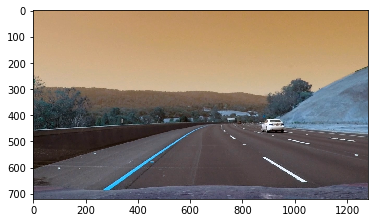

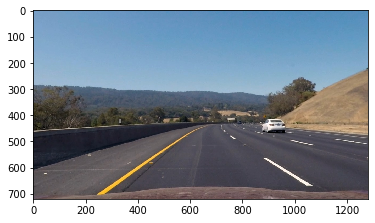

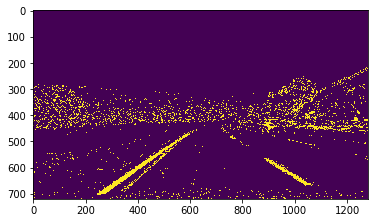

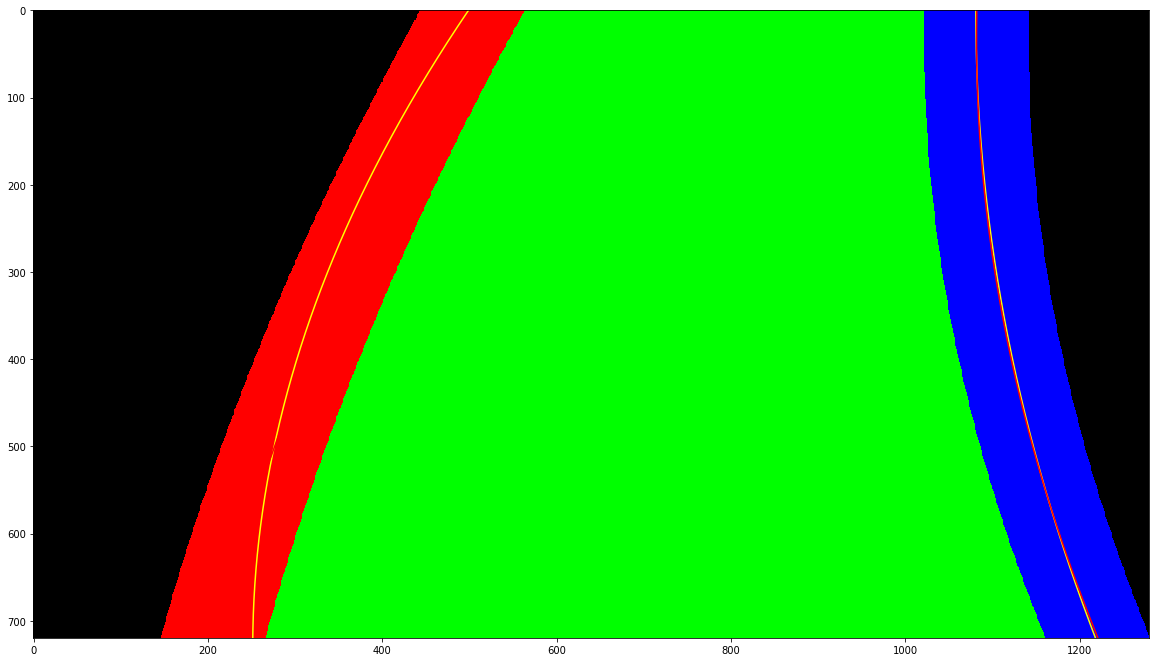

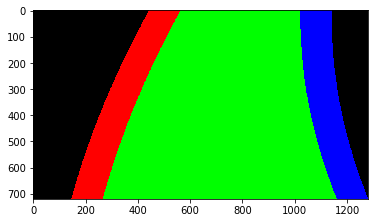

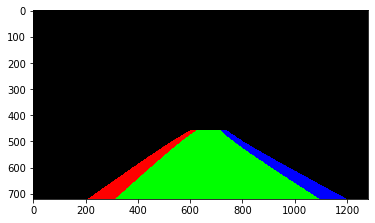

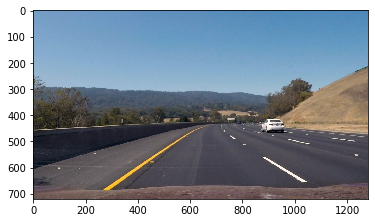

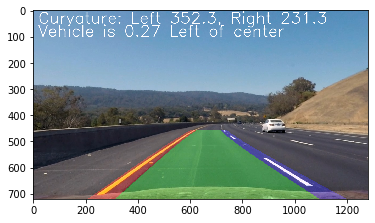

In [646]:

if True:
    new_test_case()
    Debug = True
    plt.figure()
    A = cv2.imread("test_images/test3.jpg")
    plt.imshow(A)

    input_image = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)
    res = solution(input_image)

    plt.figure()
    plt.imshow(input_image)
    
    if Print:
        save_image(res, "output.jpg")

    plt.figure()
    plt.imshow(res)

In [581]:
def play(video):
   return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

In [582]:
new_test_case()
DO = True
if DO:
    video_output = 'project_video_output.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(solution) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(video_output, audio=False)
play(video_output)

                                                                 


                                                      



                                                

                                                         
t:  15%|█▌        | 190/1260 [3:18:41<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [25:46<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [24:46<00:23, 20.13it/s, now=None]

t:   8%|▊         | 104/1260 [59:10<02:26,  7.87it/s, now=None]
                                                                 [A


                                                      



                                                

                                                         
t:  15%|█▌        | 190/1260 [3:18:41<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [25:46<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [24:46<00:23, 20.13it/s, now=None]

t:  62%|██████▏   | 112/180 [2:03:03<00:19,  3.51it/s, now=None]




t: 

E (720, 1280)
SAV (720, 1280, 3)
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4

E (720, 1280)
SAV (720, 1280, 3)







t:   0%|          | 2/1260 [00:00<01:43, 12.11it/s, now=None]




t:   0%|          | 3/1260 [00:00<02:02, 10.29it/s, now=None]




t:   0%|          | 4/1260 [00:00<02:08,  9.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   0%|          | 5/1260 [00:00<02:18,  9.07it/s, now=None]




t:   0%|          | 6/1260 [00:00<02:19,  8.99it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|          | 7/1260 [00:00<02:21,  8.85it/s, now=None]




t:   1%|          | 8/1260 [00:00<02:24,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|          | 9/1260 [00:01<02:26,  8.55it/s, now=None]




t:   1%|          | 10/1260 [00:01<02:22,  8.77it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|          | 11/1260 [00:01<02:19,  8.96it/s, now=None]




t:   1%|          | 12/1260 [00:01<02:17,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|          | 13/1260 [00:01<02:18,  9.01it/s, now=None]




t:   1%|          | 14/1260 [00:01<02:17,  9.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|          | 15/1260 [00:01<02:17,  9.07it/s, now=None]




t:   1%|▏         | 16/1260 [00:01<02:15,  9.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|▏         | 17/1260 [00:01<02:13,  9.32it/s, now=None]




t:   1%|▏         | 18/1260 [00:01<02:13,  9.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 19/1260 [00:02<02:15,  9.18it/s, now=None]




t:   2%|▏         | 20/1260 [00:02<02:16,  9.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 21/1260 [00:02<02:17,  9.02it/s, now=None]




t:   2%|▏         | 22/1260 [00:02<02:15,  9.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 23/1260 [00:02<02:17,  9.00it/s, now=None]




t:   2%|▏         | 24/1260 [00:02<02:13,  9.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 25/1260 [00:02<02:13,  9.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 27/1260 [00:02<02:10,  9.46it/s, now=None]




t:   2%|▏         | 28/1260 [00:03<02:11,  9.36it/s, now=None]




t:   2%|▏         | 29/1260 [00:03<02:11,  9.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 30/1260 [00:03<02:12,  9.32it/s, now=None]




t:   2%|▏         | 31/1260 [00:03<02:10,  9.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 32/1260 [00:03<02:12,  9.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 34/1260 [00:03<02:08,  9.52it/s, now=None]




t:   3%|▎         | 35/1260 [00:03<02:07,  9.64it/s, now=None]




t:   3%|▎         | 36/1260 [00:03<02:08,  9.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 38/1260 [00:04<02:04,  9.80it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 39/1260 [00:04<02:05,  9.76it/s, now=None]




t:   3%|▎         | 40/1260 [00:04<02:04,  9.77it/s, now=None]




t:   3%|▎         | 41/1260 [00:04<02:04,  9.77it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 42/1260 [00:04<02:07,  9.52it/s, now=None]




t:   3%|▎         | 43/1260 [00:04<02:06,  9.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 44/1260 [00:04<02:16,  8.93it/s, now=None]




t:   4%|▎         | 45/1260 [00:04<02:14,  9.01it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▎         | 46/1260 [00:04<02:13,  9.06it/s, now=None]




t:   4%|▎         | 47/1260 [00:05<02:10,  9.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▍         | 48/1260 [00:05<02:16,  8.89it/s, now=None]




t:   4%|▍         | 49/1260 [00:05<02:15,  8.96it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▍         | 50/1260 [00:05<02:15,  8.92it/s, now=None]




t:   4%|▍         | 51/1260 [00:05<02:13,  9.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▍         | 52/1260 [00:05<02:13,  9.06it/s, now=None]




t:   4%|▍         | 53/1260 [00:05<02:11,  9.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▍         | 54/1260 [00:05<02:12,  9.07it/s, now=None]




t:   4%|▍         | 55/1260 [00:05<02:11,  9.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▍         | 56/1260 [00:06<02:10,  9.23it/s, now=None]




t:   5%|▍         | 57/1260 [00:06<02:09,  9.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▍         | 58/1260 [00:06<02:17,  8.74it/s, now=None]




t:   5%|▍         | 59/1260 [00:06<02:26,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▍         | 60/1260 [00:06<02:31,  7.94it/s, now=None]




t:   5%|▍         | 61/1260 [00:06<02:36,  7.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▍         | 62/1260 [00:06<02:45,  7.24it/s, now=None]




t:   5%|▌         | 63/1260 [00:06<02:42,  7.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▌         | 64/1260 [00:07<02:46,  7.16it/s, now=None]




t:   5%|▌         | 65/1260 [00:07<02:37,  7.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▌         | 66/1260 [00:07<02:29,  7.97it/s, now=None]




t:   5%|▌         | 67/1260 [00:07<02:25,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▌         | 68/1260 [00:07<02:23,  8.33it/s, now=None]




t:   5%|▌         | 69/1260 [00:07<02:22,  8.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 70/1260 [00:07<02:21,  8.42it/s, now=None]




t:   6%|▌         | 71/1260 [00:07<02:19,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 72/1260 [00:08<02:13,  8.91it/s, now=None]




t:   6%|▌         | 73/1260 [00:08<02:13,  8.88it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 74/1260 [00:08<02:14,  8.83it/s, now=None]




t:   6%|▌         | 75/1260 [00:08<02:15,  8.76it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 76/1260 [00:08<02:16,  8.68it/s, now=None]




t:   6%|▌         | 77/1260 [00:08<02:24,  8.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 78/1260 [00:08<02:30,  7.87it/s, now=None]




t:   6%|▋         | 79/1260 [00:08<02:31,  7.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▋         | 80/1260 [00:09<02:31,  7.78it/s, now=None]




t:   6%|▋         | 81/1260 [00:09<02:23,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 82/1260 [00:09<02:20,  8.38it/s, now=None]




t:   7%|▋         | 83/1260 [00:09<02:18,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 84/1260 [00:09<02:16,  8.63it/s, now=None]




t:   7%|▋         | 85/1260 [00:09<02:15,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 86/1260 [00:09<02:16,  8.60it/s, now=None]




t:   7%|▋         | 87/1260 [00:09<02:15,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 88/1260 [00:09<02:14,  8.71it/s, now=None]




t:   7%|▋         | 89/1260 [00:10<02:14,  8.73it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 90/1260 [00:10<02:12,  8.80it/s, now=None]




t:   7%|▋         | 91/1260 [00:10<02:11,  8.89it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 92/1260 [00:10<02:13,  8.72it/s, now=None]




t:   7%|▋         | 93/1260 [00:10<02:13,  8.76it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 94/1260 [00:10<02:13,  8.77it/s, now=None]




t:   8%|▊         | 95/1260 [00:10<02:12,  8.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 96/1260 [00:10<02:12,  8.79it/s, now=None]




t:   8%|▊         | 97/1260 [00:10<02:10,  8.91it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 98/1260 [00:11<02:07,  9.10it/s, now=None]




t:   8%|▊         | 99/1260 [00:11<02:09,  8.96it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 100/1260 [00:11<02:15,  8.56it/s, now=None]




t:   8%|▊         | 101/1260 [00:11<02:15,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 102/1260 [00:11<02:17,  8.40it/s, now=None]




t:   8%|▊         | 103/1260 [00:11<02:15,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 104/1260 [00:11<02:18,  8.34it/s, now=None]




t:   8%|▊         | 105/1260 [00:11<02:20,  8.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 106/1260 [00:12<02:19,  8.28it/s, now=None]




t:   8%|▊         | 107/1260 [00:12<02:15,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▊         | 108/1260 [00:12<02:15,  8.52it/s, now=None]




t:   9%|▊         | 109/1260 [00:12<02:15,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▊         | 110/1260 [00:12<02:10,  8.78it/s, now=None]




t:   9%|▉         | 111/1260 [00:12<02:10,  8.80it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▉         | 112/1260 [00:12<02:10,  8.80it/s, now=None]




t:   9%|▉         | 113/1260 [00:12<02:10,  8.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▉         | 114/1260 [00:12<02:09,  8.82it/s, now=None]




t:   9%|▉         | 115/1260 [00:13<02:12,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▉         | 116/1260 [00:13<02:15,  8.44it/s, now=None]




t:   9%|▉         | 117/1260 [00:13<02:16,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▉         | 118/1260 [00:13<02:14,  8.50it/s, now=None]




t:   9%|▉         | 119/1260 [00:13<02:12,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|▉         | 120/1260 [00:13<02:12,  8.63it/s, now=None]




t:  10%|▉         | 121/1260 [00:13<02:10,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|▉         | 122/1260 [00:13<02:14,  8.48it/s, now=None]




t:  10%|▉         | 123/1260 [00:13<02:11,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|▉         | 124/1260 [00:14<02:08,  8.87it/s, now=None]




t:  10%|▉         | 125/1260 [00:14<02:08,  8.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|█         | 126/1260 [00:14<02:07,  8.90it/s, now=None]




t:  10%|█         | 127/1260 [00:14<02:10,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|█         | 128/1260 [00:14<02:13,  8.48it/s, now=None]




t:  10%|█         | 129/1260 [00:14<02:12,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|█         | 130/1260 [00:14<02:10,  8.63it/s, now=None]




t:  10%|█         | 131/1260 [00:14<02:10,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|█         | 132/1260 [00:15<02:10,  8.64it/s, now=None]




t:  11%|█         | 133/1260 [00:15<02:11,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█         | 134/1260 [00:15<02:09,  8.68it/s, now=None]




t:  11%|█         | 135/1260 [00:15<02:07,  8.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█         | 136/1260 [00:15<02:07,  8.81it/s, now=None]




t:  11%|█         | 137/1260 [00:15<02:05,  8.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█         | 138/1260 [00:15<02:05,  8.92it/s, now=None]




t:  11%|█         | 139/1260 [00:15<02:09,  8.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█         | 140/1260 [00:15<02:10,  8.59it/s, now=None]




t:  11%|█         | 141/1260 [00:16<02:09,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█▏        | 142/1260 [00:16<02:10,  8.57it/s, now=None]




t:  11%|█▏        | 143/1260 [00:16<02:08,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█▏        | 144/1260 [00:16<02:07,  8.78it/s, now=None]




t:  12%|█▏        | 145/1260 [00:16<02:08,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 146/1260 [00:16<02:09,  8.61it/s, now=None]




t:  12%|█▏        | 147/1260 [00:16<02:08,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 148/1260 [00:16<02:10,  8.51it/s, now=None]




t:  12%|█▏        | 149/1260 [00:16<02:09,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 150/1260 [00:17<02:08,  8.63it/s, now=None]




t:  12%|█▏        | 151/1260 [00:17<02:06,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 152/1260 [00:17<02:12,  8.35it/s, now=None]




t:  12%|█▏        | 153/1260 [00:17<02:16,  8.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 154/1260 [00:17<02:16,  8.11it/s, now=None]




t:  12%|█▏        | 155/1260 [00:17<02:11,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 156/1260 [00:17<02:08,  8.57it/s, now=None]




t:  12%|█▏        | 157/1260 [00:17<02:07,  8.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 158/1260 [00:18<02:08,  8.57it/s, now=None]




t:  13%|█▎        | 159/1260 [00:18<02:03,  8.91it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 160/1260 [00:18<02:02,  8.98it/s, now=None]




t:  13%|█▎        | 161/1260 [00:18<02:07,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 162/1260 [00:18<02:04,  8.81it/s, now=None]




t:  13%|█▎        | 163/1260 [00:18<02:02,  8.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 164/1260 [00:18<02:03,  8.85it/s, now=None]




t:  13%|█▎        | 165/1260 [00:18<02:03,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 166/1260 [00:18<02:04,  8.80it/s, now=None]




t:  13%|█▎        | 167/1260 [00:19<02:01,  9.02it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 168/1260 [00:19<02:05,  8.70it/s, now=None]




t:  13%|█▎        | 169/1260 [00:19<02:03,  8.83it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 170/1260 [00:19<02:05,  8.68it/s, now=None]




t:  14%|█▎        | 171/1260 [00:19<02:05,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▎        | 172/1260 [00:19<02:03,  8.82it/s, now=None]




t:  14%|█▎        | 173/1260 [00:19<02:05,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 174/1260 [00:19<02:05,  8.65it/s, now=None]




t:  14%|█▍        | 175/1260 [00:19<02:04,  8.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 176/1260 [00:20<02:07,  8.50it/s, now=None]




t:  14%|█▍        | 177/1260 [00:20<02:08,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 178/1260 [00:20<02:10,  8.30it/s, now=None]




t:  14%|█▍        | 179/1260 [00:20<02:08,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 180/1260 [00:20<02:08,  8.40it/s, now=None]




t:  14%|█▍        | 181/1260 [00:20<02:08,  8.42it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 182/1260 [00:20<02:08,  8.40it/s, now=None]




t:  15%|█▍        | 183/1260 [00:20<02:05,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▍        | 184/1260 [00:21<02:05,  8.56it/s, now=None]




t:  15%|█▍        | 185/1260 [00:21<02:07,  8.42it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▍        | 186/1260 [00:21<02:06,  8.46it/s, now=None]




t:  15%|█▍        | 187/1260 [00:21<02:04,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▍        | 188/1260 [00:21<02:04,  8.59it/s, now=None]




t:  15%|█▌        | 189/1260 [00:21<02:04,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▌        | 190/1260 [00:21<02:05,  8.54it/s, now=None]




t:  15%|█▌        | 191/1260 [00:21<02:04,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▌        | 192/1260 [00:22<02:07,  8.36it/s, now=None]




t:  15%|█▌        | 193/1260 [00:22<02:07,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▌        | 194/1260 [00:22<02:06,  8.41it/s, now=None]




t:  15%|█▌        | 195/1260 [00:22<02:05,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 196/1260 [00:22<02:04,  8.52it/s, now=None]




t:  16%|█▌        | 197/1260 [00:22<02:06,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 198/1260 [00:22<02:03,  8.60it/s, now=None]




t:  16%|█▌        | 199/1260 [00:22<02:03,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 200/1260 [00:22<02:04,  8.52it/s, now=None]




t:  16%|█▌        | 201/1260 [00:23<02:11,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 202/1260 [00:23<02:11,  8.06it/s, now=None]




t:  16%|█▌        | 203/1260 [00:23<02:09,  8.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 204/1260 [00:23<02:07,  8.27it/s, now=None]




t:  16%|█▋        | 205/1260 [00:23<02:09,  8.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▋        | 206/1260 [00:23<02:08,  8.23it/s, now=None]




t:  16%|█▋        | 207/1260 [00:23<02:04,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 208/1260 [00:23<02:02,  8.57it/s, now=None]




t:  17%|█▋        | 209/1260 [00:24<02:04,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 210/1260 [00:24<02:03,  8.50it/s, now=None]




t:  17%|█▋        | 211/1260 [00:24<02:02,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 212/1260 [00:24<02:05,  8.37it/s, now=None]




t:  17%|█▋        | 213/1260 [00:24<02:05,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 214/1260 [00:24<02:03,  8.45it/s, now=None]




t:  17%|█▋        | 215/1260 [00:24<02:04,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 216/1260 [00:24<02:04,  8.41it/s, now=None]




t:  17%|█▋        | 217/1260 [00:24<02:04,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 218/1260 [00:25<02:03,  8.45it/s, now=None]




t:  17%|█▋        | 219/1260 [00:25<02:02,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 220/1260 [00:25<02:04,  8.33it/s, now=None]




t:  18%|█▊        | 221/1260 [00:25<02:04,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 222/1260 [00:25<02:06,  8.23it/s, now=None]




t:  18%|█▊        | 223/1260 [00:25<02:02,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 224/1260 [00:25<01:58,  8.72it/s, now=None]




t:  18%|█▊        | 225/1260 [00:25<01:59,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 226/1260 [00:26<02:01,  8.52it/s, now=None]




t:  18%|█▊        | 227/1260 [00:26<02:01,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 228/1260 [00:26<01:59,  8.61it/s, now=None]




t:  18%|█▊        | 229/1260 [00:26<02:02,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 230/1260 [00:26<02:03,  8.36it/s, now=None]




t:  18%|█▊        | 231/1260 [00:26<01:59,  8.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 232/1260 [00:26<01:58,  8.68it/s, now=None]




t:  18%|█▊        | 233/1260 [00:26<01:57,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▊        | 234/1260 [00:26<02:00,  8.49it/s, now=None]




t:  19%|█▊        | 235/1260 [00:27<02:00,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▊        | 236/1260 [00:27<02:00,  8.53it/s, now=None]




t:  19%|█▉        | 237/1260 [00:27<01:59,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 238/1260 [00:27<02:01,  8.43it/s, now=None]




t:  19%|█▉        | 239/1260 [00:27<01:58,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 240/1260 [00:27<02:00,  8.43it/s, now=None]




t:  19%|█▉        | 241/1260 [00:27<02:05,  8.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 242/1260 [00:27<02:10,  7.79it/s, now=None]




t:  19%|█▉        | 243/1260 [00:28<02:06,  8.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 244/1260 [00:28<02:04,  8.13it/s, now=None]




t:  19%|█▉        | 245/1260 [00:28<02:05,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|█▉        | 246/1260 [00:28<02:04,  8.14it/s, now=None]




t:  20%|█▉        | 247/1260 [00:28<01:59,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|█▉        | 248/1260 [00:28<02:02,  8.29it/s, now=None]




t:  20%|█▉        | 249/1260 [00:28<02:00,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|█▉        | 250/1260 [00:28<01:59,  8.44it/s, now=None]




t:  20%|█▉        | 251/1260 [00:29<02:00,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|██        | 252/1260 [00:29<01:57,  8.55it/s, now=None]




t:  20%|██        | 253/1260 [00:29<01:58,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|██        | 254/1260 [00:29<01:59,  8.39it/s, now=None]




t:  20%|██        | 255/1260 [00:29<01:58,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|██        | 256/1260 [00:29<01:59,  8.38it/s, now=None]




t:  20%|██        | 257/1260 [00:29<01:59,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|██        | 258/1260 [00:29<01:57,  8.50it/s, now=None]




t:  21%|██        | 259/1260 [00:29<01:56,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██        | 260/1260 [00:30<01:56,  8.59it/s, now=None]




t:  21%|██        | 261/1260 [00:30<01:57,  8.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██        | 262/1260 [00:30<01:57,  8.47it/s, now=None]




t:  21%|██        | 263/1260 [00:30<01:57,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██        | 264/1260 [00:30<01:56,  8.56it/s, now=None]




t:  21%|██        | 265/1260 [00:30<01:55,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██        | 266/1260 [00:30<01:56,  8.55it/s, now=None]




t:  21%|██        | 267/1260 [00:30<01:53,  8.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██▏       | 268/1260 [00:31<01:52,  8.80it/s, now=None]




t:  21%|██▏       | 269/1260 [00:31<01:58,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██▏       | 270/1260 [00:31<01:56,  8.49it/s, now=None]




t:  22%|██▏       | 271/1260 [00:31<01:54,  8.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 272/1260 [00:31<01:55,  8.53it/s, now=None]




t:  22%|██▏       | 273/1260 [00:31<01:53,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 274/1260 [00:31<01:53,  8.68it/s, now=None]




t:  22%|██▏       | 275/1260 [00:31<01:53,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 276/1260 [00:31<01:55,  8.52it/s, now=None]




t:  22%|██▏       | 277/1260 [00:32<01:56,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 278/1260 [00:32<01:56,  8.42it/s, now=None]




t:  22%|██▏       | 279/1260 [00:32<01:55,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 280/1260 [00:32<01:55,  8.51it/s, now=None]




t:  22%|██▏       | 281/1260 [00:32<01:56,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 282/1260 [00:32<02:00,  8.12it/s, now=None]




t:  22%|██▏       | 283/1260 [00:32<01:56,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 284/1260 [00:32<01:58,  8.25it/s, now=None]




t:  23%|██▎       | 285/1260 [00:33<02:02,  7.97it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 286/1260 [00:33<02:07,  7.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 287/1260 [00:33<02:12,  7.34it/s, now=None]




t:  23%|██▎       | 288/1260 [00:33<02:13,  7.28it/s, now=None]




t:  23%|██▎       | 289/1260 [00:33<02:15,  7.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 290/1260 [00:33<02:07,  7.61it/s, now=None]




t:  23%|██▎       | 291/1260 [00:33<02:01,  7.97it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 292/1260 [00:33<02:00,  8.00it/s, now=None]




t:  23%|██▎       | 293/1260 [00:34<01:55,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 294/1260 [00:34<02:04,  7.76it/s, now=None]




t:  23%|██▎       | 295/1260 [00:34<02:04,  7.73it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 296/1260 [00:34<02:04,  7.72it/s, now=None]




t:  24%|██▎       | 297/1260 [00:34<02:01,  7.95it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▎       | 298/1260 [00:34<01:56,  8.26it/s, now=None]




t:  24%|██▎       | 299/1260 [00:34<01:57,  8.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 300/1260 [00:34<01:58,  8.10it/s, now=None]




t:  24%|██▍       | 301/1260 [00:35<01:53,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 302/1260 [00:35<01:53,  8.41it/s, now=None]




t:  24%|██▍       | 303/1260 [00:35<01:53,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 304/1260 [00:35<01:50,  8.62it/s, now=None]




t:  24%|██▍       | 305/1260 [00:35<01:50,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 306/1260 [00:35<01:53,  8.43it/s, now=None]




t:  24%|██▍       | 307/1260 [00:35<01:53,  8.43it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 308/1260 [00:35<01:53,  8.40it/s, now=None]




t:  25%|██▍       | 309/1260 [00:36<01:51,  8.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▍       | 310/1260 [00:36<01:52,  8.41it/s, now=None]




t:  25%|██▍       | 311/1260 [00:36<01:50,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▍       | 312/1260 [00:36<01:49,  8.67it/s, now=None]




t:  25%|██▍       | 313/1260 [00:36<01:48,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▍       | 314/1260 [00:36<01:47,  8.82it/s, now=None]




t:  25%|██▌       | 315/1260 [00:36<01:48,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▌       | 316/1260 [00:36<01:46,  8.86it/s, now=None]




t:  25%|██▌       | 317/1260 [00:36<01:45,  8.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▌       | 318/1260 [00:37<01:46,  8.86it/s, now=None]




t:  25%|██▌       | 319/1260 [00:37<01:50,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▌       | 320/1260 [00:37<01:49,  8.57it/s, now=None]




t:  25%|██▌       | 321/1260 [00:37<01:50,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 322/1260 [00:37<01:51,  8.39it/s, now=None]




t:  26%|██▌       | 323/1260 [00:37<01:50,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 324/1260 [00:37<01:48,  8.62it/s, now=None]




t:  26%|██▌       | 325/1260 [00:37<01:46,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 326/1260 [00:37<01:44,  8.91it/s, now=None]




t:  26%|██▌       | 327/1260 [00:38<01:49,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 328/1260 [00:38<01:53,  8.22it/s, now=None]




t:  26%|██▌       | 329/1260 [00:38<01:54,  8.14it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 330/1260 [00:38<01:53,  8.22it/s, now=None]




t:  26%|██▋       | 331/1260 [00:38<01:52,  8.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▋       | 332/1260 [00:38<01:51,  8.31it/s, now=None]




t:  26%|██▋       | 333/1260 [00:38<01:48,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 334/1260 [00:38<01:50,  8.39it/s, now=None]




t:  27%|██▋       | 335/1260 [00:39<01:51,  8.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 336/1260 [00:39<01:52,  8.18it/s, now=None]




t:  27%|██▋       | 337/1260 [00:39<01:49,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 338/1260 [00:39<01:48,  8.50it/s, now=None]




t:  27%|██▋       | 339/1260 [00:39<01:49,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 340/1260 [00:39<01:45,  8.71it/s, now=None]




t:  27%|██▋       | 341/1260 [00:39<01:46,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 342/1260 [00:39<01:46,  8.65it/s, now=None]




t:  27%|██▋       | 343/1260 [00:39<01:45,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 344/1260 [00:40<01:47,  8.48it/s, now=None]




t:  27%|██▋       | 345/1260 [00:40<01:49,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 346/1260 [00:40<01:51,  8.19it/s, now=None]




t:  28%|██▊       | 347/1260 [00:40<01:51,  8.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 348/1260 [00:40<01:52,  8.13it/s, now=None]




t:  28%|██▊       | 349/1260 [00:40<01:48,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 350/1260 [00:40<01:51,  8.16it/s, now=None]




t:  28%|██▊       | 351/1260 [00:40<01:53,  8.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 352/1260 [00:41<01:52,  8.07it/s, now=None]




t:  28%|██▊       | 353/1260 [00:41<01:48,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 354/1260 [00:41<01:45,  8.61it/s, now=None]




t:  28%|██▊       | 355/1260 [00:41<01:46,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 356/1260 [00:41<01:46,  8.46it/s, now=None]




t:  28%|██▊       | 357/1260 [00:41<01:46,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 358/1260 [00:41<01:46,  8.49it/s, now=None]




t:  28%|██▊       | 359/1260 [00:41<01:47,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▊       | 360/1260 [00:42<01:48,  8.27it/s, now=None]




t:  29%|██▊       | 361/1260 [00:42<01:47,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▊       | 362/1260 [00:42<01:49,  8.22it/s, now=None]




t:  29%|██▉       | 363/1260 [00:42<01:51,  8.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 364/1260 [00:42<01:50,  8.14it/s, now=None]




t:  29%|██▉       | 365/1260 [00:42<01:46,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 366/1260 [00:42<01:45,  8.48it/s, now=None]




t:  29%|██▉       | 367/1260 [00:42<01:45,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 368/1260 [00:42<01:43,  8.61it/s, now=None]




t:  29%|██▉       | 369/1260 [00:43<01:41,  8.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 370/1260 [00:43<01:43,  8.63it/s, now=None]




t:  29%|██▉       | 371/1260 [00:43<01:44,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|██▉       | 372/1260 [00:43<01:45,  8.43it/s, now=None]




t:  30%|██▉       | 373/1260 [00:43<01:45,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|██▉       | 374/1260 [00:43<01:44,  8.47it/s, now=None]




t:  30%|██▉       | 375/1260 [00:43<01:45,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|██▉       | 376/1260 [00:43<01:45,  8.40it/s, now=None]




t:  30%|██▉       | 377/1260 [00:44<01:45,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|███       | 378/1260 [00:44<01:43,  8.50it/s, now=None]




t:  30%|███       | 379/1260 [00:44<01:44,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|███       | 380/1260 [00:44<01:45,  8.32it/s, now=None]




t:  30%|███       | 381/1260 [00:44<01:42,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|███       | 382/1260 [00:44<01:41,  8.63it/s, now=None]




t:  30%|███       | 383/1260 [00:44<01:41,  8.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|███       | 384/1260 [00:44<01:42,  8.51it/s, now=None]




t:  31%|███       | 385/1260 [00:45<01:44,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███       | 386/1260 [00:45<01:41,  8.60it/s, now=None]




t:  31%|███       | 387/1260 [00:45<01:41,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███       | 388/1260 [00:45<01:43,  8.39it/s, now=None]




t:  31%|███       | 389/1260 [00:45<01:45,  8.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███       | 390/1260 [00:45<01:43,  8.44it/s, now=None]




t:  31%|███       | 391/1260 [00:45<01:44,  8.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███       | 392/1260 [00:45<01:43,  8.39it/s, now=None]




t:  31%|███       | 393/1260 [00:45<01:41,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███▏      | 394/1260 [00:46<01:41,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███▏      | 396/1260 [00:46<01:38,  8.81it/s, now=None]




t:  32%|███▏      | 397/1260 [00:46<01:37,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 398/1260 [00:46<01:37,  8.85it/s, now=None]




t:  32%|███▏      | 399/1260 [00:46<01:39,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 400/1260 [00:46<01:38,  8.71it/s, now=None]




t:  32%|███▏      | 401/1260 [00:46<01:41,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 402/1260 [00:46<01:40,  8.54it/s, now=None]




t:  32%|███▏      | 403/1260 [00:47<01:41,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 404/1260 [00:47<01:41,  8.44it/s, now=None]




t:  32%|███▏      | 405/1260 [00:47<01:39,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 406/1260 [00:47<01:38,  8.68it/s, now=None]




t:  32%|███▏      | 407/1260 [00:47<01:36,  8.83it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 408/1260 [00:47<01:37,  8.72it/s, now=None]




t:  32%|███▏      | 409/1260 [00:47<01:39,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 410/1260 [00:47<01:41,  8.40it/s, now=None]




t:  33%|███▎      | 411/1260 [00:48<01:40,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 412/1260 [00:48<01:42,  8.31it/s, now=None]




t:  33%|███▎      | 413/1260 [00:48<01:40,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 414/1260 [00:48<01:39,  8.51it/s, now=None]




t:  33%|███▎      | 415/1260 [00:48<01:36,  8.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 416/1260 [00:48<01:37,  8.63it/s, now=None]




t:  33%|███▎      | 417/1260 [00:48<01:40,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 418/1260 [00:48<01:39,  8.46it/s, now=None]




t:  33%|███▎      | 419/1260 [00:48<01:38,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 420/1260 [00:49<01:37,  8.65it/s, now=None]




t:  33%|███▎      | 421/1260 [00:49<01:37,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 422/1260 [00:49<01:37,  8.57it/s, now=None]




t:  34%|███▎      | 423/1260 [00:49<01:37,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▎      | 424/1260 [00:49<01:40,  8.30it/s, now=None]




t:  34%|███▎      | 425/1260 [00:49<01:42,  8.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 426/1260 [00:49<01:39,  8.38it/s, now=None]




t:  34%|███▍      | 427/1260 [00:49<01:39,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 428/1260 [00:50<01:39,  8.38it/s, now=None]




t:  34%|███▍      | 429/1260 [00:50<01:39,  8.31it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 430/1260 [00:50<01:40,  8.25it/s, now=None]




t:  34%|███▍      | 431/1260 [00:50<01:37,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 432/1260 [00:50<01:41,  8.17it/s, now=None]




t:  34%|███▍      | 433/1260 [00:50<01:40,  8.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 434/1260 [00:50<01:40,  8.22it/s, now=None]




t:  35%|███▍      | 435/1260 [00:50<01:39,  8.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▍      | 436/1260 [00:51<01:39,  8.24it/s, now=None]




t:  35%|███▍      | 437/1260 [00:51<01:37,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▍      | 438/1260 [00:51<01:37,  8.44it/s, now=None]




t:  35%|███▍      | 439/1260 [00:51<01:36,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▍      | 440/1260 [00:51<01:37,  8.40it/s, now=None]




t:  35%|███▌      | 441/1260 [00:51<01:40,  8.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▌      | 442/1260 [00:51<01:36,  8.44it/s, now=None]




t:  35%|███▌      | 443/1260 [00:51<01:36,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▌      | 444/1260 [00:51<01:37,  8.38it/s, now=None]




t:  35%|███▌      | 445/1260 [00:52<01:37,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▌      | 446/1260 [00:52<01:37,  8.38it/s, now=None]




t:  35%|███▌      | 447/1260 [00:52<01:34,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 448/1260 [00:52<01:36,  8.40it/s, now=None]




t:  36%|███▌      | 449/1260 [00:52<01:37,  8.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 450/1260 [00:52<01:35,  8.50it/s, now=None]




t:  36%|███▌      | 451/1260 [00:52<01:35,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 452/1260 [00:52<01:37,  8.32it/s, now=None]




t:  36%|███▌      | 453/1260 [00:53<01:36,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 454/1260 [00:53<01:35,  8.46it/s, now=None]




t:  36%|███▌      | 455/1260 [00:53<01:36,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 456/1260 [00:53<01:37,  8.27it/s, now=None]




t:  36%|███▋      | 457/1260 [00:53<01:34,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▋      | 458/1260 [00:53<01:34,  8.48it/s, now=None]




t:  36%|███▋      | 459/1260 [00:53<01:32,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 460/1260 [00:53<01:33,  8.56it/s, now=None]




t:  37%|███▋      | 461/1260 [00:53<01:33,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 462/1260 [00:54<01:35,  8.38it/s, now=None]




t:  37%|███▋      | 463/1260 [00:54<01:36,  8.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 464/1260 [00:54<01:36,  8.28it/s, now=None]




t:  37%|███▋      | 465/1260 [00:54<01:35,  8.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 466/1260 [00:54<01:35,  8.31it/s, now=None]




t:  37%|███▋      | 467/1260 [00:54<01:34,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 468/1260 [00:54<01:36,  8.24it/s, now=None]




t:  37%|███▋      | 469/1260 [00:54<01:35,  8.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 470/1260 [00:55<01:33,  8.47it/s, now=None]




t:  37%|███▋      | 471/1260 [00:55<01:33,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 472/1260 [00:55<01:31,  8.63it/s, now=None]




t:  38%|███▊      | 473/1260 [00:55<01:34,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 474/1260 [00:55<01:39,  7.89it/s, now=None]




t:  38%|███▊      | 475/1260 [00:55<01:38,  7.95it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 476/1260 [00:55<01:38,  7.98it/s, now=None]




t:  38%|███▊      | 477/1260 [00:55<01:40,  7.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 478/1260 [00:56<01:37,  7.98it/s, now=None]




t:  38%|███▊      | 479/1260 [00:56<01:36,  8.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 480/1260 [00:56<01:35,  8.13it/s, now=None]




t:  38%|███▊      | 481/1260 [00:56<01:35,  8.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 482/1260 [00:56<01:33,  8.28it/s, now=None]




t:  38%|███▊      | 483/1260 [00:56<01:33,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 484/1260 [00:56<01:32,  8.37it/s, now=None]




t:  38%|███▊      | 485/1260 [00:56<01:32,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▊      | 486/1260 [00:57<01:32,  8.34it/s, now=None]




t:  39%|███▊      | 487/1260 [00:57<01:31,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▊      | 488/1260 [00:57<01:34,  8.15it/s, now=None]




t:  39%|███▉      | 489/1260 [00:57<01:32,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▉      | 490/1260 [00:57<01:32,  8.29it/s, now=None]




t:  39%|███▉      | 491/1260 [00:57<01:32,  8.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▉      | 492/1260 [00:57<01:33,  8.24it/s, now=None]




t:  39%|███▉      | 493/1260 [00:57<01:32,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▉      | 494/1260 [00:57<01:32,  8.29it/s, now=None]




t:  39%|███▉      | 495/1260 [00:58<01:30,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▉      | 496/1260 [00:58<01:29,  8.50it/s, now=None]




t:  39%|███▉      | 497/1260 [00:58<01:30,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|███▉      | 498/1260 [00:58<01:32,  8.24it/s, now=None]




t:  40%|███▉      | 499/1260 [00:58<01:34,  8.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|███▉      | 500/1260 [00:58<01:36,  7.86it/s, now=None]




t:  40%|███▉      | 501/1260 [00:58<01:35,  7.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|███▉      | 502/1260 [00:58<01:33,  8.08it/s, now=None]




t:  40%|███▉      | 503/1260 [00:59<01:35,  7.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|████      | 504/1260 [00:59<01:41,  7.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|████      | 505/1260 [00:59<01:44,  7.23it/s, now=None]




t:  40%|████      | 506/1260 [00:59<01:45,  7.13it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  40%|████      | 507/1260 [00:59<01:46,  7.06it/s, now=None]




t:  40%|████      | 508/1260 [00:59<01:43,  7.26it/s, now=None]




t:  40%|████      | 509/1260 [00:59<01:38,  7.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|████      | 510/1260 [01:00<01:34,  7.93it/s, now=None]




t:  41%|████      | 511/1260 [01:00<01:34,  7.90it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████      | 512/1260 [01:00<01:42,  7.29it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  41%|████      | 513/1260 [01:00<01:42,  7.30it/s, now=None]




t:  41%|████      | 514/1260 [01:00<01:40,  7.46it/s, now=None]




t:  41%|████      | 515/1260 [01:00<01:37,  7.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████      | 516/1260 [01:00<01:38,  7.52it/s, now=None]




t:  41%|████      | 517/1260 [01:00<01:39,  7.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████      | 518/1260 [01:01<01:36,  7.68it/s, now=None]




t:  41%|████      | 519/1260 [01:01<01:35,  7.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████▏     | 520/1260 [01:01<01:34,  7.82it/s, now=None]




t:  41%|████▏     | 521/1260 [01:01<01:35,  7.77it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████▏     | 522/1260 [01:01<01:36,  7.64it/s, now=None]




t:  42%|████▏     | 523/1260 [01:01<01:39,  7.42it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 524/1260 [01:01<01:40,  7.35it/s, now=None]




t:  42%|████▏     | 525/1260 [01:02<01:38,  7.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 526/1260 [01:02<01:35,  7.70it/s, now=None]




t:  42%|████▏     | 527/1260 [01:02<01:36,  7.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 528/1260 [01:02<01:38,  7.42it/s, now=None]




t:  42%|████▏     | 529/1260 [01:02<01:40,  7.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 530/1260 [01:02<01:42,  7.13it/s, now=None]




t:  42%|████▏     | 531/1260 [01:02<01:41,  7.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 532/1260 [01:03<01:40,  7.23it/s, now=None]




t:  42%|████▏     | 533/1260 [01:03<01:38,  7.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 534/1260 [01:03<01:34,  7.66it/s, now=None]




t:  42%|████▏     | 535/1260 [01:03<01:33,  7.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 536/1260 [01:03<01:32,  7.85it/s, now=None]




t:  43%|████▎     | 537/1260 [01:03<01:30,  8.02it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 538/1260 [01:03<01:27,  8.22it/s, now=None]




t:  43%|████▎     | 539/1260 [01:03<01:29,  8.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 540/1260 [01:03<01:30,  7.92it/s, now=None]




t:  43%|████▎     | 541/1260 [01:04<01:30,  7.98it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 542/1260 [01:04<01:29,  8.00it/s, now=None]




t:  43%|████▎     | 543/1260 [01:04<01:30,  7.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 544/1260 [01:04<01:29,  7.99it/s, now=None]




t:  43%|████▎     | 545/1260 [01:04<01:33,  7.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 546/1260 [01:04<01:32,  7.71it/s, now=None]




t:  43%|████▎     | 547/1260 [01:04<01:31,  7.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 548/1260 [01:05<01:30,  7.90it/s, now=None]




t:  44%|████▎     | 549/1260 [01:05<01:30,  7.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  44%|████▎     | 550/1260 [01:05<01:28,  7.99it/s, now=None]




t:  44%|████▎     | 551/1260 [01:05<01:31,  7.77it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  44%|████▍     | 552/1260 [01:05<01:30,  7.85it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  44%|████▍     | 553/1260 [01:05<01:35,  7.40it/s, now=None]




t:  44%|████▍     | 554/1260 [01:05<01:36,  7.34it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  44%|████▍     | 555/1260 [01:05<01:38,  7.14it/s, now=None]




t:  44%|████▍     | 556/1260 [01:06<01:37,  7.20it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  44%|████▍     | 557/1260 [01:06<01:38,  7.10it/s, now=None]




t:  44%|████▍     | 558/1260 [01:06<01:36,  7.25it/s, now=None]




t:  44%|████▍     | 559/1260 [01:06<01:32,  7.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  44%|████▍     | 560/1260 [01:06<01:28,  7.89it/s, now=None]




t:  45%|████▍     | 561/1260 [01:06<01:26,  8.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▍     | 562/1260 [01:06<01:29,  7.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▍     | 563/1260 [01:07<01:34,  7.36it/s, now=None]




t:  45%|████▍     | 564/1260 [01:07<01:33,  7.43it/s, now=None]




t:  45%|████▍     | 565/1260 [01:07<01:36,  7.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▍     | 566/1260 [01:07<01:36,  7.23it/s, now=None]




t:  45%|████▌     | 567/1260 [01:07<01:31,  7.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▌     | 568/1260 [01:07<01:33,  7.42it/s, now=None]




t:  45%|████▌     | 569/1260 [01:07<01:34,  7.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▌     | 570/1260 [01:07<01:33,  7.35it/s, now=None]




t:  45%|████▌     | 571/1260 [01:08<01:32,  7.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▌     | 572/1260 [01:08<01:30,  7.61it/s, now=None]




t:  45%|████▌     | 573/1260 [01:08<01:31,  7.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 574/1260 [01:08<01:35,  7.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 575/1260 [01:08<01:37,  7.03it/s, now=None]




t:  46%|████▌     | 576/1260 [01:08<01:36,  7.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 577/1260 [01:08<01:39,  6.88it/s, now=None]




t:  46%|████▌     | 578/1260 [01:09<01:38,  6.90it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 579/1260 [01:09<01:43,  6.60it/s, now=None]




t:  46%|████▌     | 580/1260 [01:09<01:45,  6.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 581/1260 [01:09<01:49,  6.20it/s, now=None]




t:  46%|████▌     | 582/1260 [01:09<01:55,  5.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▋     | 583/1260 [01:09<01:58,  5.70it/s, now=None]




t:  46%|████▋     | 584/1260 [01:10<01:50,  6.12it/s, now=None]




t:  46%|████▋     | 585/1260 [01:10<01:46,  6.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 586/1260 [01:10<01:41,  6.67it/s, now=None]




t:  47%|████▋     | 587/1260 [01:10<01:34,  7.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 588/1260 [01:10<01:31,  7.32it/s, now=None]




t:  47%|████▋     | 589/1260 [01:10<01:30,  7.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 590/1260 [01:10<01:30,  7.40it/s, now=None]




t:  47%|████▋     | 591/1260 [01:11<01:28,  7.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 592/1260 [01:11<01:29,  7.49it/s, now=None]




t:  47%|████▋     | 593/1260 [01:11<01:29,  7.42it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 594/1260 [01:11<01:30,  7.37it/s, now=None]




t:  47%|████▋     | 595/1260 [01:11<01:31,  7.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 596/1260 [01:11<01:35,  6.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 597/1260 [01:11<01:42,  6.44it/s, now=None]




t:  47%|████▋     | 598/1260 [01:12<01:45,  6.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 599/1260 [01:12<01:45,  6.24it/s, now=None]




t:  48%|████▊     | 600/1260 [01:12<01:44,  6.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 601/1260 [01:12<01:44,  6.30it/s, now=None]




t:  48%|████▊     | 602/1260 [01:12<01:44,  6.31it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  48%|████▊     | 603/1260 [01:12<01:40,  6.57it/s, now=None]




t:  48%|████▊     | 604/1260 [01:13<01:34,  6.91it/s, now=None]




t:  48%|████▊     | 605/1260 [01:13<01:32,  7.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 606/1260 [01:13<01:33,  7.00it/s, now=None]




t:  48%|████▊     | 607/1260 [01:13<01:30,  7.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 608/1260 [01:13<01:28,  7.36it/s, now=None]




t:  48%|████▊     | 609/1260 [01:13<01:25,  7.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 610/1260 [01:13<01:24,  7.71it/s, now=None]




t:  48%|████▊     | 611/1260 [01:13<01:23,  7.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▊     | 612/1260 [01:14<01:21,  7.92it/s, now=None]




t:  49%|████▊     | 613/1260 [01:14<01:22,  7.82it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▊     | 614/1260 [01:14<01:18,  8.19it/s, now=None]




t:  49%|████▉     | 615/1260 [01:14<01:17,  8.32it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▉     | 616/1260 [01:14<01:16,  8.37it/s, now=None]




t:  49%|████▉     | 617/1260 [01:14<01:14,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▉     | 618/1260 [01:14<01:13,  8.71it/s, now=None]




t:  49%|████▉     | 619/1260 [01:14<01:15,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▉     | 620/1260 [01:14<01:12,  8.78it/s, now=None]




t:  49%|████▉     | 621/1260 [01:15<01:11,  8.95it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▉     | 622/1260 [01:15<01:11,  8.88it/s, now=None]




t:  49%|████▉     | 623/1260 [01:15<01:14,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|████▉     | 624/1260 [01:15<01:18,  8.13it/s, now=None]




t:  50%|████▉     | 625/1260 [01:15<01:17,  8.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|████▉     | 626/1260 [01:15<01:17,  8.22it/s, now=None]




t:  50%|████▉     | 627/1260 [01:15<01:14,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|████▉     | 628/1260 [01:15<01:14,  8.43it/s, now=None]




t:  50%|████▉     | 629/1260 [01:16<01:19,  7.93it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|█████     | 630/1260 [01:16<01:19,  7.95it/s, now=None]




t:  50%|█████     | 631/1260 [01:16<01:15,  8.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|█████     | 632/1260 [01:16<01:13,  8.49it/s, now=None]




t:  50%|█████     | 633/1260 [01:16<01:14,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|█████     | 634/1260 [01:16<01:14,  8.36it/s, now=None]




t:  50%|█████     | 635/1260 [01:16<01:13,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|█████     | 636/1260 [01:16<01:12,  8.64it/s, now=None]




t:  51%|█████     | 637/1260 [01:16<01:12,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████     | 638/1260 [01:17<01:11,  8.68it/s, now=None]




t:  51%|█████     | 639/1260 [01:17<01:10,  8.82it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████     | 640/1260 [01:17<01:09,  8.94it/s, now=None]




t:  51%|█████     | 641/1260 [01:17<01:10,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████     | 642/1260 [01:17<01:11,  8.67it/s, now=None]




t:  51%|█████     | 643/1260 [01:17<01:10,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████     | 644/1260 [01:17<01:12,  8.51it/s, now=None]




t:  51%|█████     | 645/1260 [01:17<01:14,  8.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████▏    | 646/1260 [01:18<01:13,  8.35it/s, now=None]




t:  51%|█████▏    | 647/1260 [01:18<01:13,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████▏    | 648/1260 [01:18<01:11,  8.57it/s, now=None]




t:  52%|█████▏    | 649/1260 [01:18<01:11,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 650/1260 [01:18<01:11,  8.49it/s, now=None]




t:  52%|█████▏    | 651/1260 [01:18<01:13,  8.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 652/1260 [01:18<01:13,  8.22it/s, now=None]




t:  52%|█████▏    | 653/1260 [01:18<01:14,  8.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 654/1260 [01:19<01:18,  7.73it/s, now=None]




t:  52%|█████▏    | 655/1260 [01:19<01:15,  7.98it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 656/1260 [01:19<01:16,  7.91it/s, now=None]




t:  52%|█████▏    | 657/1260 [01:19<01:16,  7.90it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 658/1260 [01:19<01:16,  7.85it/s, now=None]




t:  52%|█████▏    | 659/1260 [01:19<01:14,  8.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 660/1260 [01:19<01:13,  8.15it/s, now=None]




t:  52%|█████▏    | 661/1260 [01:19<01:13,  8.14it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 662/1260 [01:20<01:12,  8.19it/s, now=None]




t:  53%|█████▎    | 663/1260 [01:20<01:14,  7.99it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 664/1260 [01:20<01:16,  7.76it/s, now=None]




t:  53%|█████▎    | 665/1260 [01:20<01:17,  7.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 666/1260 [01:20<01:14,  7.96it/s, now=None]




t:  53%|█████▎    | 667/1260 [01:20<01:13,  8.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 668/1260 [01:20<01:11,  8.23it/s, now=None]




t:  53%|█████▎    | 669/1260 [01:20<01:13,  8.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 670/1260 [01:21<01:14,  7.87it/s, now=None]




t:  53%|█████▎    | 671/1260 [01:21<01:11,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 672/1260 [01:21<01:10,  8.29it/s, now=None]




t:  53%|█████▎    | 673/1260 [01:21<01:09,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 674/1260 [01:21<01:07,  8.66it/s, now=None]




t:  54%|█████▎    | 675/1260 [01:21<01:08,  8.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▎    | 676/1260 [01:21<01:08,  8.52it/s, now=None]




t:  54%|█████▎    | 677/1260 [01:21<01:07,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 678/1260 [01:21<01:09,  8.38it/s, now=None]




t:  54%|█████▍    | 679/1260 [01:22<01:09,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 680/1260 [01:22<01:08,  8.43it/s, now=None]




t:  54%|█████▍    | 681/1260 [01:22<01:08,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 682/1260 [01:22<01:08,  8.42it/s, now=None]




t:  54%|█████▍    | 683/1260 [01:22<01:08,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 684/1260 [01:22<01:09,  8.25it/s, now=None]




t:  54%|█████▍    | 685/1260 [01:22<01:08,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 686/1260 [01:22<01:08,  8.39it/s, now=None]




t:  55%|█████▍    | 687/1260 [01:23<01:09,  8.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▍    | 688/1260 [01:23<01:09,  8.27it/s, now=None]




t:  55%|█████▍    | 689/1260 [01:23<01:10,  8.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▍    | 690/1260 [01:23<01:11,  7.99it/s, now=None]




t:  55%|█████▍    | 691/1260 [01:23<01:09,  8.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▍    | 692/1260 [01:23<01:09,  8.18it/s, now=None]




t:  55%|█████▌    | 693/1260 [01:23<01:08,  8.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▌    | 694/1260 [01:23<01:08,  8.21it/s, now=None]




t:  55%|█████▌    | 695/1260 [01:24<01:13,  7.73it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▌    | 696/1260 [01:24<01:18,  7.14it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▌    | 697/1260 [01:24<01:19,  7.10it/s, now=None]




t:  55%|█████▌    | 698/1260 [01:24<01:16,  7.36it/s, now=None]




t:  55%|█████▌    | 699/1260 [01:24<01:12,  7.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▌    | 700/1260 [01:24<01:12,  7.72it/s, now=None]




t:  56%|█████▌    | 701/1260 [01:24<01:11,  7.80it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▌    | 702/1260 [01:24<01:10,  7.90it/s, now=None]




t:  56%|█████▌    | 703/1260 [01:25<01:08,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▌    | 704/1260 [01:25<01:08,  8.12it/s, now=None]




t:  56%|█████▌    | 705/1260 [01:25<01:06,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▌    | 706/1260 [01:25<01:06,  8.33it/s, now=None]




t:  56%|█████▌    | 707/1260 [01:25<01:04,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▌    | 708/1260 [01:25<01:06,  8.34it/s, now=None]




t:  56%|█████▋    | 709/1260 [01:25<01:03,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▋    | 710/1260 [01:25<01:03,  8.66it/s, now=None]




t:  56%|█████▋    | 711/1260 [01:26<01:07,  8.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 712/1260 [01:26<01:10,  7.74it/s, now=None]




t:  57%|█████▋    | 713/1260 [01:26<01:10,  7.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 714/1260 [01:26<01:13,  7.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 715/1260 [01:26<01:18,  6.94it/s, now=None]




t:  57%|█████▋    | 716/1260 [01:26<01:22,  6.62it/s, now=None]




t:  57%|█████▋    | 717/1260 [01:26<01:17,  7.05it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 718/1260 [01:27<01:17,  7.03it/s, now=None]




t:  57%|█████▋    | 719/1260 [01:27<01:15,  7.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 720/1260 [01:27<01:17,  6.97it/s, now=None]




t:  57%|█████▋    | 721/1260 [01:27<01:18,  6.89it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 722/1260 [01:27<01:15,  7.12it/s, now=None]




t:  57%|█████▋    | 723/1260 [01:27<01:16,  7.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 724/1260 [01:27<01:13,  7.31it/s, now=None]




t:  58%|█████▊    | 725/1260 [01:27<01:09,  7.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 726/1260 [01:28<01:07,  7.90it/s, now=None]




t:  58%|█████▊    | 727/1260 [01:28<01:05,  8.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 728/1260 [01:28<01:07,  7.91it/s, now=None]




t:  58%|█████▊    | 729/1260 [01:28<01:07,  7.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 730/1260 [01:28<01:07,  7.85it/s, now=None]




t:  58%|█████▊    | 731/1260 [01:28<01:06,  8.01it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 732/1260 [01:28<01:06,  7.96it/s, now=None]




t:  58%|█████▊    | 733/1260 [01:28<01:04,  8.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 734/1260 [01:29<01:04,  8.15it/s, now=None]




t:  58%|█████▊    | 735/1260 [01:29<01:02,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 736/1260 [01:29<01:01,  8.53it/s, now=None]




t:  58%|█████▊    | 737/1260 [01:29<01:00,  8.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▊    | 738/1260 [01:29<00:59,  8.76it/s, now=None]




t:  59%|█████▊    | 739/1260 [01:29<01:00,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▊    | 740/1260 [01:29<01:01,  8.47it/s, now=None]




t:  59%|█████▉    | 741/1260 [01:29<01:01,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▉    | 742/1260 [01:30<01:03,  8.22it/s, now=None]




t:  59%|█████▉    | 743/1260 [01:30<01:00,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▉    | 744/1260 [01:30<01:01,  8.40it/s, now=None]




t:  59%|█████▉    | 745/1260 [01:30<01:06,  7.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▉    | 746/1260 [01:30<01:09,  7.40it/s, now=None]




t:  59%|█████▉    | 747/1260 [01:30<01:09,  7.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▉    | 748/1260 [01:30<01:12,  7.05it/s, now=None]






E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


t:  59%|█████▉    | 749/1260 [01:31<01:12,  7.03it/s, now=None]




t:  60%|█████▉    | 750/1260 [01:31<01:16,  6.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|█████▉    | 751/1260 [01:31<01:15,  6.78it/s, now=None]




t:  60%|█████▉    | 752/1260 [01:31<01:14,  6.80it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|█████▉    | 753/1260 [01:31<01:14,  6.80it/s, now=None]




t:  60%|█████▉    | 754/1260 [01:31<01:13,  6.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|█████▉    | 755/1260 [01:31<01:16,  6.57it/s, now=None]




t:  60%|██████    | 756/1260 [01:32<01:15,  6.68it/s, now=None]




t:  60%|██████    | 757/1260 [01:32<01:10,  7.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|██████    | 758/1260 [01:32<01:05,  7.68it/s, now=None]




t:  60%|██████    | 759/1260 [01:32<01:02,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|██████    | 760/1260 [01:32<01:01,  8.09it/s, now=None]




t:  60%|██████    | 761/1260 [01:32<00:59,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|██████    | 762/1260 [01:32<00:57,  8.60it/s, now=None]




t:  61%|██████    | 763/1260 [01:32<00:58,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████    | 764/1260 [01:32<00:58,  8.43it/s, now=None]




t:  61%|██████    | 765/1260 [01:33<00:58,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████    | 766/1260 [01:33<00:57,  8.54it/s, now=None]




t:  61%|██████    | 767/1260 [01:33<00:56,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████    | 768/1260 [01:33<00:57,  8.62it/s, now=None]




t:  61%|██████    | 769/1260 [01:33<00:58,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████    | 770/1260 [01:33<00:56,  8.63it/s, now=None]




t:  61%|██████    | 771/1260 [01:33<00:59,  8.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████▏   | 772/1260 [01:33<00:59,  8.21it/s, now=None]




t:  61%|██████▏   | 773/1260 [01:34<00:59,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████▏   | 774/1260 [01:34<00:57,  8.49it/s, now=None]




t:  62%|██████▏   | 775/1260 [01:34<00:57,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 776/1260 [01:34<00:57,  8.41it/s, now=None]




t:  62%|██████▏   | 777/1260 [01:34<00:56,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 778/1260 [01:34<00:56,  8.59it/s, now=None]




t:  62%|██████▏   | 779/1260 [01:34<00:55,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 780/1260 [01:34<00:56,  8.52it/s, now=None]




t:  62%|██████▏   | 781/1260 [01:34<00:55,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 782/1260 [01:35<00:56,  8.53it/s, now=None]




t:  62%|██████▏   | 783/1260 [01:35<00:56,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 784/1260 [01:35<00:56,  8.39it/s, now=None]




t:  62%|██████▏   | 785/1260 [01:35<00:57,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 786/1260 [01:35<00:56,  8.42it/s, now=None]




t:  62%|██████▏   | 787/1260 [01:35<00:56,  8.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 788/1260 [01:35<00:57,  8.14it/s, now=None]




t:  63%|██████▎   | 789/1260 [01:35<00:55,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 790/1260 [01:36<00:54,  8.57it/s, now=None]




t:  63%|██████▎   | 791/1260 [01:36<00:55,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 792/1260 [01:36<00:57,  8.08it/s, now=None]




t:  63%|██████▎   | 793/1260 [01:36<00:57,  8.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 794/1260 [01:36<00:57,  8.12it/s, now=None]




t:  63%|██████▎   | 795/1260 [01:36<00:56,  8.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 796/1260 [01:36<00:55,  8.31it/s, now=None]




t:  63%|██████▎   | 797/1260 [01:36<00:56,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 798/1260 [01:37<00:56,  8.17it/s, now=None]




t:  63%|██████▎   | 799/1260 [01:37<00:55,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 800/1260 [01:37<00:54,  8.46it/s, now=None]




t:  64%|██████▎   | 801/1260 [01:37<00:54,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▎   | 802/1260 [01:37<00:56,  8.16it/s, now=None]




t:  64%|██████▎   | 803/1260 [01:37<00:55,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▍   | 804/1260 [01:37<00:54,  8.37it/s, now=None]




t:  64%|██████▍   | 805/1260 [01:37<00:55,  8.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▍   | 806/1260 [01:37<00:54,  8.39it/s, now=None]




t:  64%|██████▍   | 807/1260 [01:38<00:53,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▍   | 808/1260 [01:38<00:51,  8.75it/s, now=None]




t:  64%|██████▍   | 809/1260 [01:38<00:50,  8.90it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▍   | 810/1260 [01:38<00:50,  8.96it/s, now=None]




t:  64%|██████▍   | 811/1260 [01:38<00:51,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▍   | 812/1260 [01:38<00:53,  8.35it/s, now=None]




t:  65%|██████▍   | 813/1260 [01:38<00:54,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▍   | 814/1260 [01:38<00:53,  8.36it/s, now=None]




t:  65%|██████▍   | 815/1260 [01:39<00:52,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▍   | 816/1260 [01:39<00:52,  8.49it/s, now=None]




t:  65%|██████▍   | 817/1260 [01:39<00:51,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▍   | 818/1260 [01:39<00:51,  8.55it/s, now=None]




t:  65%|██████▌   | 819/1260 [01:39<00:53,  8.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▌   | 820/1260 [01:39<00:53,  8.22it/s, now=None]




t:  65%|██████▌   | 821/1260 [01:39<00:52,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▌   | 822/1260 [01:39<00:50,  8.64it/s, now=None]




t:  65%|██████▌   | 823/1260 [01:39<00:51,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▌   | 824/1260 [01:40<00:52,  8.36it/s, now=None]




t:  65%|██████▌   | 825/1260 [01:40<00:51,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 826/1260 [01:40<00:51,  8.47it/s, now=None]




t:  66%|██████▌   | 827/1260 [01:40<00:51,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 828/1260 [01:40<00:50,  8.60it/s, now=None]




t:  66%|██████▌   | 829/1260 [01:40<00:51,  8.31it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 830/1260 [01:40<00:50,  8.51it/s, now=None]




t:  66%|██████▌   | 831/1260 [01:40<00:52,  8.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 832/1260 [01:41<00:52,  8.17it/s, now=None]




t:  66%|██████▌   | 833/1260 [01:41<00:53,  8.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 834/1260 [01:41<00:54,  7.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▋   | 835/1260 [01:41<00:57,  7.45it/s, now=None]




t:  66%|██████▋   | 836/1260 [01:41<00:57,  7.35it/s, now=None]




t:  66%|██████▋   | 837/1260 [01:41<00:56,  7.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 838/1260 [01:41<00:56,  7.42it/s, now=None]




t:  67%|██████▋   | 839/1260 [01:42<00:56,  7.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 840/1260 [01:42<00:56,  7.49it/s, now=None]




t:  67%|██████▋   | 841/1260 [01:42<00:54,  7.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 842/1260 [01:42<00:54,  7.70it/s, now=None]




t:  67%|██████▋   | 843/1260 [01:42<00:54,  7.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 844/1260 [01:42<00:56,  7.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 845/1260 [01:42<00:58,  7.14it/s, now=None]




t:  67%|██████▋   | 846/1260 [01:42<00:58,  7.05it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 847/1260 [01:43<00:59,  6.98it/s, now=None]




t:  67%|██████▋   | 848/1260 [01:43<00:59,  6.88it/s, now=None]




t:  67%|██████▋   | 849/1260 [01:43<00:58,  7.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 850/1260 [01:43<00:58,  7.03it/s, now=None]




t:  68%|██████▊   | 851/1260 [01:43<00:56,  7.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 852/1260 [01:43<00:55,  7.32it/s, now=None]




t:  68%|██████▊   | 853/1260 [01:43<00:55,  7.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 854/1260 [01:44<00:56,  7.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 855/1260 [01:44<00:58,  6.96it/s, now=None]




t:  68%|██████▊   | 856/1260 [01:44<00:58,  6.86it/s, now=None]




t:  68%|██████▊   | 857/1260 [01:44<00:57,  7.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 858/1260 [01:44<00:54,  7.36it/s, now=None]




t:  68%|██████▊   | 859/1260 [01:44<00:53,  7.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 860/1260 [01:44<00:52,  7.56it/s, now=None]




t:  68%|██████▊   | 861/1260 [01:45<00:52,  7.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 862/1260 [01:45<00:49,  8.04it/s, now=None]




t:  68%|██████▊   | 863/1260 [01:45<00:49,  8.00it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▊   | 864/1260 [01:45<00:49,  8.07it/s, now=None]




t:  69%|██████▊   | 865/1260 [01:45<00:47,  8.31it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▊   | 866/1260 [01:45<00:48,  8.15it/s, now=None]




t:  69%|██████▉   | 867/1260 [01:45<00:48,  8.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▉   | 868/1260 [01:45<00:48,  8.03it/s, now=None]




t:  69%|██████▉   | 869/1260 [01:46<00:47,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▉   | 870/1260 [01:46<00:46,  8.37it/s, now=None]




t:  69%|██████▉   | 871/1260 [01:46<00:47,  8.18it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▉   | 872/1260 [01:46<00:47,  8.21it/s, now=None]




t:  69%|██████▉   | 873/1260 [01:46<00:46,  8.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▉   | 874/1260 [01:46<00:46,  8.24it/s, now=None]




t:  69%|██████▉   | 875/1260 [01:46<00:46,  8.32it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|██████▉   | 876/1260 [01:46<00:46,  8.29it/s, now=None]




t:  70%|██████▉   | 877/1260 [01:46<00:45,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|██████▉   | 878/1260 [01:47<00:43,  8.76it/s, now=None]




t:  70%|██████▉   | 879/1260 [01:47<00:43,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|██████▉   | 880/1260 [01:47<00:43,  8.74it/s, now=None]




t:  70%|██████▉   | 881/1260 [01:47<00:43,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|███████   | 882/1260 [01:47<00:43,  8.63it/s, now=None]




t:  70%|███████   | 883/1260 [01:47<00:43,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|███████   | 884/1260 [01:47<00:43,  8.58it/s, now=None]




t:  70%|███████   | 885/1260 [01:47<00:43,  8.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|███████   | 886/1260 [01:47<00:43,  8.65it/s, now=None]




t:  70%|███████   | 887/1260 [01:48<00:42,  8.76it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|███████   | 888/1260 [01:48<00:41,  8.97it/s, now=None]




t:  71%|███████   | 889/1260 [01:48<00:41,  8.86it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████   | 890/1260 [01:48<00:41,  8.82it/s, now=None]




t:  71%|███████   | 891/1260 [01:48<00:42,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████   | 892/1260 [01:48<00:42,  8.58it/s, now=None]




t:  71%|███████   | 893/1260 [01:48<00:42,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████   | 894/1260 [01:48<00:43,  8.32it/s, now=None]




t:  71%|███████   | 895/1260 [01:49<00:45,  8.00it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████   | 896/1260 [01:49<00:45,  7.96it/s, now=None]




t:  71%|███████   | 897/1260 [01:49<00:45,  8.02it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████▏  | 898/1260 [01:49<00:45,  7.93it/s, now=None]




t:  71%|███████▏  | 899/1260 [01:49<00:44,  8.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████▏  | 900/1260 [01:49<00:44,  8.15it/s, now=None]




t:  72%|███████▏  | 901/1260 [01:49<00:43,  8.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 902/1260 [01:49<00:44,  7.98it/s, now=None]




t:  72%|███████▏  | 903/1260 [01:50<00:44,  8.05it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 904/1260 [01:50<00:44,  7.94it/s, now=None]




t:  72%|███████▏  | 905/1260 [01:50<00:44,  8.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 906/1260 [01:50<00:43,  8.07it/s, now=None]




t:  72%|███████▏  | 907/1260 [01:50<00:42,  8.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 908/1260 [01:50<00:43,  8.14it/s, now=None]




t:  72%|███████▏  | 909/1260 [01:50<00:42,  8.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 910/1260 [01:50<00:42,  8.32it/s, now=None]




t:  72%|███████▏  | 911/1260 [01:51<00:42,  8.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 912/1260 [01:51<00:42,  8.22it/s, now=None]




t:  72%|███████▏  | 913/1260 [01:51<00:41,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 914/1260 [01:51<00:41,  8.36it/s, now=None]




t:  73%|███████▎  | 915/1260 [01:51<00:41,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 916/1260 [01:51<00:42,  8.04it/s, now=None]




t:  73%|███████▎  | 917/1260 [01:51<00:42,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 918/1260 [01:51<00:41,  8.21it/s, now=None]




t:  73%|███████▎  | 919/1260 [01:52<00:41,  8.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 920/1260 [01:52<00:41,  8.15it/s, now=None]




t:  73%|███████▎  | 921/1260 [01:52<00:40,  8.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 922/1260 [01:52<00:40,  8.45it/s, now=None]




t:  73%|███████▎  | 923/1260 [01:52<00:39,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 924/1260 [01:52<00:39,  8.54it/s, now=None]




t:  73%|███████▎  | 925/1260 [01:52<00:39,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 926/1260 [01:52<00:40,  8.31it/s, now=None]




t:  74%|███████▎  | 927/1260 [01:52<00:40,  8.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▎  | 928/1260 [01:53<00:39,  8.35it/s, now=None]




t:  74%|███████▎  | 929/1260 [01:53<00:39,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 930/1260 [01:53<00:38,  8.62it/s, now=None]




t:  74%|███████▍  | 931/1260 [01:53<00:38,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 932/1260 [01:53<00:38,  8.52it/s, now=None]




t:  74%|███████▍  | 933/1260 [01:53<00:38,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 934/1260 [01:53<00:37,  8.62it/s, now=None]




t:  74%|███████▍  | 935/1260 [01:53<00:37,  8.72it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 936/1260 [01:54<00:37,  8.59it/s, now=None]




t:  74%|███████▍  | 937/1260 [01:54<00:37,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 938/1260 [01:54<00:37,  8.56it/s, now=None]




t:  75%|███████▍  | 939/1260 [01:54<00:38,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▍  | 940/1260 [01:54<00:38,  8.39it/s, now=None]




t:  75%|███████▍  | 941/1260 [01:54<00:38,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▍  | 942/1260 [01:54<00:37,  8.52it/s, now=None]




t:  75%|███████▍  | 943/1260 [01:54<00:36,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▍  | 944/1260 [01:54<00:37,  8.47it/s, now=None]




t:  75%|███████▌  | 945/1260 [01:55<00:36,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▌  | 946/1260 [01:55<00:37,  8.44it/s, now=None]




t:  75%|███████▌  | 947/1260 [01:55<00:38,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▌  | 948/1260 [01:55<00:39,  7.99it/s, now=None]




t:  75%|███████▌  | 949/1260 [01:55<00:39,  7.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▌  | 950/1260 [01:55<00:39,  7.93it/s, now=None]




t:  75%|███████▌  | 951/1260 [01:55<00:39,  7.80it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▌  | 952/1260 [01:55<00:38,  8.04it/s, now=None]




t:  76%|███████▌  | 953/1260 [01:56<00:36,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▌  | 954/1260 [01:56<00:35,  8.70it/s, now=None]




t:  76%|███████▌  | 955/1260 [01:56<00:34,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▌  | 956/1260 [01:56<00:34,  8.78it/s, now=None]




t:  76%|███████▌  | 957/1260 [01:56<00:35,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▌  | 958/1260 [01:56<00:36,  8.17it/s, now=None]




t:  76%|███████▌  | 959/1260 [01:56<00:37,  8.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▌  | 960/1260 [01:56<00:37,  8.09it/s, now=None]




t:  76%|███████▋  | 961/1260 [01:57<00:35,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▋  | 962/1260 [01:57<00:34,  8.56it/s, now=None]




t:  76%|███████▋  | 963/1260 [01:57<00:35,  8.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 964/1260 [01:57<00:35,  8.44it/s, now=None]




t:  77%|███████▋  | 965/1260 [01:57<00:34,  8.43it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 966/1260 [01:57<00:34,  8.47it/s, now=None]




t:  77%|███████▋  | 967/1260 [01:57<00:34,  8.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 968/1260 [01:57<00:34,  8.51it/s, now=None]




t:  77%|███████▋  | 969/1260 [01:57<00:34,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 970/1260 [01:58<00:34,  8.36it/s, now=None]




t:  77%|███████▋  | 971/1260 [01:58<00:34,  8.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 972/1260 [01:58<00:35,  8.23it/s, now=None]




t:  77%|███████▋  | 973/1260 [01:58<00:35,  8.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 974/1260 [01:58<00:34,  8.35it/s, now=None]




t:  77%|███████▋  | 975/1260 [01:58<00:35,  8.00it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 976/1260 [01:58<00:34,  8.21it/s, now=None]




t:  78%|███████▊  | 977/1260 [01:58<00:34,  8.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 978/1260 [01:59<00:35,  7.87it/s, now=None]




t:  78%|███████▊  | 979/1260 [01:59<00:34,  8.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 980/1260 [01:59<00:34,  8.09it/s, now=None]




t:  78%|███████▊  | 981/1260 [01:59<00:33,  8.32it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 982/1260 [01:59<00:32,  8.56it/s, now=None]




t:  78%|███████▊  | 983/1260 [01:59<00:32,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 984/1260 [01:59<00:32,  8.62it/s, now=None]




t:  78%|███████▊  | 985/1260 [01:59<00:32,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 986/1260 [02:00<00:33,  8.14it/s, now=None]




t:  78%|███████▊  | 987/1260 [02:00<00:34,  7.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 988/1260 [02:00<00:35,  7.76it/s, now=None]




t:  78%|███████▊  | 989/1260 [02:00<00:35,  7.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▊  | 990/1260 [02:00<00:33,  7.96it/s, now=None]




t:  79%|███████▊  | 991/1260 [02:00<00:32,  8.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▊  | 992/1260 [02:00<00:32,  8.32it/s, now=None]




t:  79%|███████▉  | 993/1260 [02:00<00:32,  8.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▉  | 994/1260 [02:01<00:31,  8.39it/s, now=None]




t:  79%|███████▉  | 995/1260 [02:01<00:31,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▉  | 996/1260 [02:01<00:31,  8.27it/s, now=None]




t:  79%|███████▉  | 997/1260 [02:01<00:31,  8.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▉  | 998/1260 [02:01<00:32,  8.14it/s, now=None]




t:  79%|███████▉  | 999/1260 [02:01<00:32,  8.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▉  | 1000/1260 [02:01<00:32,  7.91it/s, now=None]




t:  79%|███████▉  | 1001/1260 [02:01<00:31,  8.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|███████▉  | 1002/1260 [02:01<00:31,  8.21it/s, now=None]




t:  80%|███████▉  | 1003/1260 [02:02<00:31,  8.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|███████▉  | 1004/1260 [02:02<00:30,  8.47it/s, now=None]




t:  80%|███████▉  | 1005/1260 [02:02<00:30,  8.32it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|███████▉  | 1006/1260 [02:02<00:30,  8.20it/s, now=None]




t:  80%|███████▉  | 1007/1260 [02:02<00:32,  7.90it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|████████  | 1008/1260 [02:02<00:31,  7.94it/s, now=None]




t:  80%|████████  | 1009/1260 [02:02<00:31,  8.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|████████  | 1010/1260 [02:02<00:29,  8.41it/s, now=None]




t:  80%|████████  | 1011/1260 [02:03<00:29,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|████████  | 1012/1260 [02:03<00:29,  8.37it/s, now=None]




t:  80%|████████  | 1013/1260 [02:03<00:29,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|████████  | 1014/1260 [02:03<00:30,  8.14it/s, now=None]




t:  81%|████████  | 1015/1260 [02:03<00:30,  8.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 1016/1260 [02:03<00:30,  7.91it/s, now=None]




t:  81%|████████  | 1017/1260 [02:03<00:31,  7.73it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 1018/1260 [02:03<00:31,  7.60it/s, now=None]




t:  81%|████████  | 1019/1260 [02:04<00:31,  7.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 1020/1260 [02:04<00:30,  7.90it/s, now=None]




t:  81%|████████  | 1021/1260 [02:04<00:29,  8.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 1022/1260 [02:04<00:28,  8.23it/s, now=None]




t:  81%|████████  | 1023/1260 [02:04<00:28,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████▏ | 1024/1260 [02:04<00:29,  7.97it/s, now=None]




t:  81%|████████▏ | 1025/1260 [02:04<00:29,  7.89it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████▏ | 1026/1260 [02:04<00:29,  7.85it/s, now=None]




t:  82%|████████▏ | 1027/1260 [02:05<00:29,  7.96it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 1028/1260 [02:05<00:28,  8.09it/s, now=None]




t:  82%|████████▏ | 1029/1260 [02:05<00:27,  8.38it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 1030/1260 [02:05<00:26,  8.74it/s, now=None]




t:  82%|████████▏ | 1031/1260 [02:05<00:26,  8.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 1032/1260 [02:05<00:26,  8.70it/s, now=None]




t:  82%|████████▏ | 1033/1260 [02:05<00:26,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 1034/1260 [02:05<00:25,  8.94it/s, now=None]




t:  82%|████████▏ | 1035/1260 [02:05<00:25,  8.98it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 1036/1260 [02:06<00:25,  8.81it/s, now=None]




t:  82%|████████▏ | 1037/1260 [02:06<00:25,  8.72it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 1038/1260 [02:06<00:25,  8.76it/s, now=None]




t:  82%|████████▏ | 1039/1260 [02:06<00:25,  8.72it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1040/1260 [02:06<00:25,  8.77it/s, now=None]




t:  83%|████████▎ | 1041/1260 [02:06<00:24,  9.00it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1042/1260 [02:06<00:24,  9.05it/s, now=None]




t:  83%|████████▎ | 1043/1260 [02:06<00:24,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1044/1260 [02:07<00:24,  8.88it/s, now=None]




t:  83%|████████▎ | 1045/1260 [02:07<00:24,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1047/1260 [02:07<00:23,  9.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1048/1260 [02:07<00:23,  9.07it/s, now=None]




t:  83%|████████▎ | 1049/1260 [02:07<00:23,  9.05it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1050/1260 [02:07<00:23,  9.08it/s, now=None]




t:  83%|████████▎ | 1051/1260 [02:07<00:22,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 1052/1260 [02:07<00:22,  9.26it/s, now=None]




t:  84%|████████▎ | 1053/1260 [02:07<00:23,  8.99it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▎ | 1054/1260 [02:08<00:23,  8.75it/s, now=None]




t:  84%|████████▎ | 1055/1260 [02:08<00:23,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▍ | 1056/1260 [02:08<00:23,  8.60it/s, now=None]




t:  84%|████████▍ | 1057/1260 [02:08<00:23,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▍ | 1058/1260 [02:08<00:23,  8.49it/s, now=None]




t:  84%|████████▍ | 1059/1260 [02:08<00:22,  8.86it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▍ | 1060/1260 [02:08<00:22,  8.87it/s, now=None]




t:  84%|████████▍ | 1061/1260 [02:08<00:22,  8.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▍ | 1062/1260 [02:09<00:22,  8.63it/s, now=None]




t:  84%|████████▍ | 1063/1260 [02:09<00:22,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▍ | 1064/1260 [02:09<00:22,  8.73it/s, now=None]




t:  85%|████████▍ | 1065/1260 [02:09<00:22,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▍ | 1066/1260 [02:09<00:22,  8.53it/s, now=None]




t:  85%|████████▍ | 1067/1260 [02:09<00:22,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▍ | 1068/1260 [02:09<00:22,  8.61it/s, now=None]




t:  85%|████████▍ | 1069/1260 [02:09<00:22,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▍ | 1070/1260 [02:09<00:23,  8.21it/s, now=None]




t:  85%|████████▌ | 1071/1260 [02:10<00:22,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▌ | 1072/1260 [02:10<00:21,  8.86it/s, now=None]




t:  85%|████████▌ | 1073/1260 [02:10<00:21,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▌ | 1074/1260 [02:10<00:21,  8.69it/s, now=None]




t:  85%|████████▌ | 1075/1260 [02:10<00:21,  8.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▌ | 1076/1260 [02:10<00:21,  8.53it/s, now=None]




t:  85%|████████▌ | 1077/1260 [02:10<00:21,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 1078/1260 [02:10<00:21,  8.50it/s, now=None]




t:  86%|████████▌ | 1079/1260 [02:11<00:21,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 1080/1260 [02:11<00:21,  8.38it/s, now=None]




t:  86%|████████▌ | 1081/1260 [02:11<00:21,  8.22it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 1082/1260 [02:11<00:21,  8.25it/s, now=None]




t:  86%|████████▌ | 1083/1260 [02:11<00:21,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 1084/1260 [02:11<00:21,  8.31it/s, now=None]




t:  86%|████████▌ | 1085/1260 [02:11<00:20,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 1086/1260 [02:11<00:20,  8.55it/s, now=None]




t:  86%|████████▋ | 1087/1260 [02:11<00:20,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▋ | 1088/1260 [02:12<00:20,  8.53it/s, now=None]




t:  86%|████████▋ | 1089/1260 [02:12<00:20,  8.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1090/1260 [02:12<00:20,  8.21it/s, now=None]




t:  87%|████████▋ | 1091/1260 [02:12<00:20,  8.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1092/1260 [02:12<00:20,  8.20it/s, now=None]




t:  87%|████████▋ | 1093/1260 [02:12<00:20,  8.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1094/1260 [02:12<00:20,  8.23it/s, now=None]




t:  87%|████████▋ | 1095/1260 [02:12<00:19,  8.31it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1096/1260 [02:13<00:20,  8.17it/s, now=None]




t:  87%|████████▋ | 1097/1260 [02:13<00:19,  8.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1098/1260 [02:13<00:19,  8.46it/s, now=None]




t:  87%|████████▋ | 1099/1260 [02:13<00:19,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1100/1260 [02:13<00:19,  8.39it/s, now=None]




t:  87%|████████▋ | 1101/1260 [02:13<00:19,  8.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 1102/1260 [02:13<00:18,  8.32it/s, now=None]




t:  88%|████████▊ | 1103/1260 [02:13<00:18,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 1104/1260 [02:14<00:18,  8.37it/s, now=None]




t:  88%|████████▊ | 1105/1260 [02:14<00:18,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 1106/1260 [02:14<00:17,  8.56it/s, now=None]




t:  88%|████████▊ | 1107/1260 [02:14<00:18,  8.31it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 1108/1260 [02:14<00:18,  8.33it/s, now=None]




t:  88%|████████▊ | 1109/1260 [02:14<00:17,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 1110/1260 [02:14<00:17,  8.55it/s, now=None]




t:  88%|████████▊ | 1111/1260 [02:14<00:17,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 1112/1260 [02:14<00:17,  8.69it/s, now=None]




t:  88%|████████▊ | 1113/1260 [02:15<00:16,  8.73it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 1114/1260 [02:15<00:16,  8.87it/s, now=None]




t:  88%|████████▊ | 1115/1260 [02:15<00:16,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▊ | 1116/1260 [02:15<00:16,  8.70it/s, now=None]




t:  89%|████████▊ | 1117/1260 [02:15<00:16,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▊ | 1118/1260 [02:15<00:16,  8.68it/s, now=None]




t:  89%|████████▉ | 1119/1260 [02:15<00:16,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▉ | 1120/1260 [02:15<00:16,  8.36it/s, now=None]




t:  89%|████████▉ | 1121/1260 [02:16<00:16,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▉ | 1122/1260 [02:16<00:16,  8.39it/s, now=None]




t:  89%|████████▉ | 1123/1260 [02:16<00:16,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▉ | 1124/1260 [02:16<00:16,  8.48it/s, now=None]




t:  89%|████████▉ | 1125/1260 [02:16<00:15,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▉ | 1126/1260 [02:16<00:15,  8.63it/s, now=None]




t:  89%|████████▉ | 1127/1260 [02:16<00:15,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|████████▉ | 1128/1260 [02:16<00:15,  8.41it/s, now=None]




t:  90%|████████▉ | 1129/1260 [02:16<00:15,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|████████▉ | 1130/1260 [02:17<00:15,  8.32it/s, now=None]




t:  90%|████████▉ | 1131/1260 [02:17<00:15,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|████████▉ | 1132/1260 [02:17<00:14,  8.54it/s, now=None]




t:  90%|████████▉ | 1133/1260 [02:17<00:15,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|█████████ | 1134/1260 [02:17<00:14,  8.40it/s, now=None]




t:  90%|█████████ | 1135/1260 [02:17<00:14,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|█████████ | 1136/1260 [02:17<00:14,  8.50it/s, now=None]




t:  90%|█████████ | 1137/1260 [02:17<00:14,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|█████████ | 1138/1260 [02:18<00:14,  8.59it/s, now=None]




t:  90%|█████████ | 1139/1260 [02:18<00:14,  8.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|█████████ | 1140/1260 [02:18<00:14,  8.50it/s, now=None]




t:  91%|█████████ | 1141/1260 [02:18<00:14,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████ | 1142/1260 [02:18<00:14,  8.37it/s, now=None]




t:  91%|█████████ | 1143/1260 [02:18<00:13,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████ | 1144/1260 [02:18<00:13,  8.47it/s, now=None]




t:  91%|█████████ | 1145/1260 [02:18<00:13,  8.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████ | 1146/1260 [02:18<00:13,  8.35it/s, now=None]




t:  91%|█████████ | 1147/1260 [02:19<00:13,  8.44it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████ | 1148/1260 [02:19<00:13,  8.54it/s, now=None]




t:  91%|█████████ | 1149/1260 [02:19<00:13,  8.43it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████▏| 1150/1260 [02:19<00:12,  8.55it/s, now=None]




t:  91%|█████████▏| 1151/1260 [02:19<00:12,  8.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████▏| 1152/1260 [02:19<00:12,  8.67it/s, now=None]




t:  92%|█████████▏| 1153/1260 [02:19<00:12,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 1154/1260 [02:19<00:12,  8.47it/s, now=None]




t:  92%|█████████▏| 1155/1260 [02:20<00:12,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 1156/1260 [02:20<00:11,  8.77it/s, now=None]




t:  92%|█████████▏| 1157/1260 [02:20<00:12,  8.53it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 1158/1260 [02:20<00:11,  8.73it/s, now=None]




t:  92%|█████████▏| 1159/1260 [02:20<00:11,  8.72it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 1160/1260 [02:20<00:11,  8.84it/s, now=None]




t:  92%|█████████▏| 1161/1260 [02:20<00:11,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 1162/1260 [02:20<00:11,  8.83it/s, now=None]




t:  92%|█████████▏| 1163/1260 [02:20<00:10,  8.82it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 1164/1260 [02:21<00:11,  8.67it/s, now=None]




t:  92%|█████████▏| 1165/1260 [02:21<00:11,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1166/1260 [02:21<00:10,  8.68it/s, now=None]




t:  93%|█████████▎| 1167/1260 [02:21<00:10,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1168/1260 [02:21<00:10,  8.81it/s, now=None]




t:  93%|█████████▎| 1169/1260 [02:21<00:10,  9.01it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1170/1260 [02:21<00:10,  8.78it/s, now=None]




t:  93%|█████████▎| 1171/1260 [02:21<00:10,  8.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1172/1260 [02:21<00:09,  8.82it/s, now=None]




t:  93%|█████████▎| 1173/1260 [02:22<00:10,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1174/1260 [02:22<00:09,  8.74it/s, now=None]




t:  93%|█████████▎| 1175/1260 [02:22<00:09,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1176/1260 [02:22<00:09,  8.73it/s, now=None]




t:  93%|█████████▎| 1177/1260 [02:22<00:09,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 1178/1260 [02:22<00:09,  8.49it/s, now=None]




t:  94%|█████████▎| 1179/1260 [02:22<00:09,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▎| 1180/1260 [02:22<00:09,  8.37it/s, now=None]




t:  94%|█████████▎| 1181/1260 [02:23<00:09,  8.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 1182/1260 [02:23<00:09,  8.21it/s, now=None]




t:  94%|█████████▍| 1183/1260 [02:23<00:09,  8.32it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 1184/1260 [02:23<00:08,  8.65it/s, now=None]




t:  94%|█████████▍| 1185/1260 [02:23<00:08,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 1186/1260 [02:23<00:08,  8.45it/s, now=None]




t:  94%|█████████▍| 1187/1260 [02:23<00:08,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 1188/1260 [02:23<00:08,  8.76it/s, now=None]




t:  94%|█████████▍| 1189/1260 [02:23<00:08,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 1190/1260 [02:24<00:08,  8.43it/s, now=None]




t:  95%|█████████▍| 1191/1260 [02:24<00:08,  8.42it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▍| 1192/1260 [02:24<00:07,  8.55it/s, now=None]




t:  95%|█████████▍| 1193/1260 [02:24<00:07,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▍| 1194/1260 [02:24<00:07,  8.62it/s, now=None]




t:  95%|█████████▍| 1195/1260 [02:24<00:07,  8.83it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▍| 1196/1260 [02:24<00:07,  8.72it/s, now=None]




t:  95%|█████████▌| 1197/1260 [02:24<00:07,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▌| 1198/1260 [02:24<00:07,  8.73it/s, now=None]




t:  95%|█████████▌| 1199/1260 [02:25<00:07,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▌| 1200/1260 [02:25<00:07,  8.51it/s, now=None]




t:  95%|█████████▌| 1201/1260 [02:25<00:07,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▌| 1202/1260 [02:25<00:06,  8.37it/s, now=None]




t:  95%|█████████▌| 1203/1260 [02:25<00:06,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▌| 1204/1260 [02:25<00:06,  8.68it/s, now=None]




t:  96%|█████████▌| 1205/1260 [02:25<00:06,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▌| 1206/1260 [02:25<00:06,  8.45it/s, now=None]




t:  96%|█████████▌| 1207/1260 [02:26<00:06,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▌| 1208/1260 [02:26<00:05,  8.87it/s, now=None]




t:  96%|█████████▌| 1209/1260 [02:26<00:05,  8.69it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▌| 1210/1260 [02:26<00:05,  8.78it/s, now=None]




t:  96%|█████████▌| 1211/1260 [02:26<00:05,  9.02it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▌| 1212/1260 [02:26<00:05,  8.92it/s, now=None]




t:  96%|█████████▋| 1213/1260 [02:26<00:05,  8.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▋| 1214/1260 [02:26<00:05,  8.57it/s, now=None]




t:  96%|█████████▋| 1215/1260 [02:26<00:05,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1216/1260 [02:27<00:05,  8.45it/s, now=None]




t:  97%|█████████▋| 1217/1260 [02:27<00:04,  8.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1218/1260 [02:27<00:04,  8.76it/s, now=None]




t:  97%|█████████▋| 1219/1260 [02:27<00:04,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1220/1260 [02:27<00:04,  8.64it/s, now=None]




t:  97%|█████████▋| 1221/1260 [02:27<00:04,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1222/1260 [02:27<00:04,  8.42it/s, now=None]




t:  97%|█████████▋| 1223/1260 [02:27<00:04,  8.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1224/1260 [02:28<00:04,  8.58it/s, now=None]




t:  97%|█████████▋| 1225/1260 [02:28<00:04,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1226/1260 [02:28<00:03,  8.68it/s, now=None]




t:  97%|█████████▋| 1227/1260 [02:28<00:03,  8.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 1228/1260 [02:28<00:03,  8.41it/s, now=None]




t:  98%|█████████▊| 1229/1260 [02:28<00:03,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 1230/1260 [02:28<00:03,  8.36it/s, now=None]




t:  98%|█████████▊| 1231/1260 [02:28<00:03,  8.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 1232/1260 [02:28<00:03,  8.35it/s, now=None]




t:  98%|█████████▊| 1233/1260 [02:29<00:03,  8.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 1234/1260 [02:29<00:03,  8.31it/s, now=None]




t:  98%|█████████▊| 1235/1260 [02:29<00:02,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 1236/1260 [02:29<00:02,  8.36it/s, now=None]




t:  98%|█████████▊| 1237/1260 [02:29<00:02,  8.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 1238/1260 [02:29<00:02,  8.34it/s, now=None]




t:  98%|█████████▊| 1239/1260 [02:29<00:02,  8.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 1240/1260 [02:29<00:02,  8.28it/s, now=None]




t:  98%|█████████▊| 1241/1260 [02:30<00:02,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▊| 1242/1260 [02:30<00:02,  8.51it/s, now=None]




t:  99%|█████████▊| 1243/1260 [02:30<00:01,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▊| 1244/1260 [02:30<00:01,  8.47it/s, now=None]




t:  99%|█████████▉| 1245/1260 [02:30<00:01,  8.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▉| 1246/1260 [02:30<00:01,  8.39it/s, now=None]




t:  99%|█████████▉| 1247/1260 [02:30<00:01,  8.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▉| 1248/1260 [02:30<00:01,  8.43it/s, now=None]




t:  99%|█████████▉| 1249/1260 [02:30<00:01,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▉| 1250/1260 [02:31<00:01,  8.24it/s, now=None]




t:  99%|█████████▉| 1251/1260 [02:31<00:01,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▉| 1252/1260 [02:31<00:00,  8.49it/s, now=None]




t:  99%|█████████▉| 1253/1260 [02:31<00:00,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t: 100%|█████████▉| 1254/1260 [02:31<00:00,  8.62it/s, now=None]




t: 100%|█████████▉| 1255/1260 [02:31<00:00,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t: 100%|█████████▉| 1256/1260 [02:31<00:00,  8.83it/s, now=None]




t: 100%|█████████▉| 1257/1260 [02:31<00:00,  8.88it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t: 100%|█████████▉| 1258/1260 [02:32<00:00,  8.81it/s, now=None]




t: 100%|█████████▉| 1259/1260 [02:32<00:00,  9.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t: 100%|██████████| 1260/1260 [02:32<00:00,  9.05it/s, now=None]




                                                                

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


                                                                 


                                                      



                                                

                                                         
t:  15%|█▌        | 190/1260 [3:21:14<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [28:19<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [27:18<00:23, 20.13it/s, now=None]

t:   8%|▊         | 104/1260 [1:01:43<02:26,  7.87it/s, now=None]
                                                                 [A


                                                      



                                                

                                                           
t:  15%|█▌        | 190/1260 [3:21:14<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [28:19<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [27:18<00:23, 20.13it/s, now=None]

t:  62%|██████▏   | 112/180 [2:05:36<00:19,  3.51it/s, now=None]

Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 14min 47s, sys: 41.2 s, total: 15min 29s
Wall time: 2min 32s


In [583]:
new_test_case(debug = False)
DO = True 
if DO:
    video_output = 'challenge_video_output.mp4'
    chell_clip1 = VideoFileClip("challenge_video.mp4")
    chell_clip = chell_clip1.fl_image(solution)
    %time chell_clip.write_videofile(video_output, audio=False)
play(video_output)

                                                                 


                                                      



                                                

                                                           
t:  15%|█▌        | 190/1260 [3:21:14<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [28:20<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [27:19<00:23, 20.13it/s, now=None]

t:   8%|▊         | 104/1260 [1:01:44<02:26,  7.87it/s, now=None]
                                                                 [A


                                                      



                                                

                                                           
t:  15%|█▌        | 190/1260 [3:21:14<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [28:20<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [27:19<00:23, 20.13it/s, now=None]

t:  62%|██████▏   | 112/180 [2:05:36<00:19,  3.51it/s, now=None]



E (720, 1280)
SAV (720, 1280, 3)
Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4

E (720, 1280)
SAV (720, 1280, 3)







t:   0%|          | 2/485 [00:00<00:27, 17.59it/s, now=None]




t:   1%|          | 3/485 [00:00<00:36, 13.23it/s, now=None]




t:   1%|          | 4/485 [00:00<00:40, 11.92it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|          | 5/485 [00:00<00:47, 10.15it/s, now=None]




t:   1%|          | 6/485 [00:00<00:48,  9.89it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   1%|▏         | 7/485 [00:00<00:50,  9.46it/s, now=None]




t:   2%|▏         | 8/485 [00:00<00:53,  8.92it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 9/485 [00:00<00:52,  9.03it/s, now=None]




t:   2%|▏         | 10/485 [00:01<00:51,  9.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   2%|▏         | 11/485 [00:01<00:50,  9.35it/s, now=None]




t:   2%|▏         | 12/485 [00:01<00:49,  9.51it/s, now=None]




t:   3%|▎         | 13/485 [00:01<00:50,  9.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 14/485 [00:01<00:50,  9.35it/s, now=None]




t:   3%|▎         | 15/485 [00:01<00:51,  9.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   3%|▎         | 16/485 [00:01<00:50,  9.32it/s, now=None]




t:   4%|▎         | 17/485 [00:01<00:51,  9.14it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▎         | 18/485 [00:01<00:50,  9.16it/s, now=None]




t:   4%|▍         | 19/485 [00:02<00:51,  9.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   4%|▍         | 20/485 [00:02<00:50,  9.13it/s, now=None]




t:   4%|▍         | 21/485 [00:02<00:50,  9.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▍         | 22/485 [00:02<00:50,  9.17it/s, now=None]




t:   5%|▍         | 23/485 [00:02<00:50,  9.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▍         | 24/485 [00:02<00:51,  9.00it/s, now=None]




t:   5%|▌         | 25/485 [00:02<00:50,  9.14it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   5%|▌         | 26/485 [00:02<00:50,  9.02it/s, now=None]




t:   6%|▌         | 27/485 [00:02<00:50,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 28/485 [00:02<00:49,  9.15it/s, now=None]




t:   6%|▌         | 29/485 [00:03<00:49,  9.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   6%|▌         | 30/485 [00:03<00:49,  9.10it/s, now=None]




t:   6%|▋         | 31/485 [00:03<00:49,  9.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 32/485 [00:03<00:48,  9.28it/s, now=None]




t:   7%|▋         | 33/485 [00:03<00:48,  9.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 34/485 [00:03<00:48,  9.24it/s, now=None]




t:   7%|▋         | 35/485 [00:03<00:49,  9.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   7%|▋         | 36/485 [00:03<00:49,  9.06it/s, now=None]




t:   8%|▊         | 37/485 [00:03<00:49,  9.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 38/485 [00:04<00:48,  9.30it/s, now=None]




t:   8%|▊         | 39/485 [00:04<00:48,  9.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   8%|▊         | 40/485 [00:04<00:48,  9.22it/s, now=None]




t:   8%|▊         | 41/485 [00:04<00:48,  9.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▊         | 42/485 [00:04<00:47,  9.25it/s, now=None]




t:   9%|▉         | 43/485 [00:04<00:47,  9.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▉         | 44/485 [00:04<00:49,  8.98it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:   9%|▉         | 46/485 [00:04<00:47,  9.19it/s, now=None]




t:  10%|▉         | 47/485 [00:05<00:48,  9.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|█         | 49/485 [00:05<00:46,  9.28it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  10%|█         | 50/485 [00:05<00:46,  9.29it/s, now=None]




t:  11%|█         | 51/485 [00:05<00:47,  9.19it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█         | 52/485 [00:05<00:47,  9.20it/s, now=None]




t:  11%|█         | 53/485 [00:05<00:46,  9.32it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  11%|█         | 54/485 [00:05<00:48,  8.97it/s, now=None]




t:  11%|█▏        | 55/485 [00:05<00:46,  9.18it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 56/485 [00:06<00:47,  9.12it/s, now=None]




t:  12%|█▏        | 57/485 [00:06<00:48,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 58/485 [00:06<00:48,  8.87it/s, now=None]




t:  12%|█▏        | 59/485 [00:06<00:47,  8.97it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  12%|█▏        | 60/485 [00:06<00:46,  9.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 62/485 [00:06<00:45,  9.25it/s, now=None]




t:  13%|█▎        | 63/485 [00:06<00:45,  9.34it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  13%|█▎        | 64/485 [00:06<00:44,  9.45it/s, now=None]




t:  13%|█▎        | 65/485 [00:07<00:45,  9.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▎        | 66/485 [00:07<00:45,  9.21it/s, now=None]




t:  14%|█▍        | 67/485 [00:07<00:45,  9.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 68/485 [00:07<00:45,  9.21it/s, now=None]




t:  14%|█▍        | 69/485 [00:07<00:44,  9.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  14%|█▍        | 70/485 [00:07<00:44,  9.23it/s, now=None]




t:  15%|█▍        | 71/485 [00:07<00:45,  9.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▍        | 72/485 [00:07<00:45,  9.09it/s, now=None]




t:  15%|█▌        | 73/485 [00:07<00:45,  8.98it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  15%|█▌        | 74/485 [00:07<00:44,  9.19it/s, now=None]




t:  15%|█▌        | 75/485 [00:08<00:44,  9.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 76/485 [00:08<00:43,  9.35it/s, now=None]




t:  16%|█▌        | 77/485 [00:08<00:43,  9.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▌        | 78/485 [00:08<00:44,  9.16it/s, now=None]




t:  16%|█▋        | 79/485 [00:08<00:43,  9.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  16%|█▋        | 80/485 [00:08<00:42,  9.49it/s, now=None]




t:  17%|█▋        | 81/485 [00:08<00:43,  9.35it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 82/485 [00:08<00:42,  9.38it/s, now=None]




t:  17%|█▋        | 83/485 [00:08<00:42,  9.36it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  17%|█▋        | 84/485 [00:09<00:42,  9.53it/s, now=None]




t:  18%|█▊        | 85/485 [00:09<00:42,  9.47it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 86/485 [00:09<00:43,  9.27it/s, now=None]




t:  18%|█▊        | 87/485 [00:09<00:43,  9.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  18%|█▊        | 88/485 [00:09<00:42,  9.27it/s, now=None]




t:  18%|█▊        | 89/485 [00:09<00:43,  9.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 91/485 [00:09<00:42,  9.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 92/485 [00:09<00:42,  9.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  19%|█▉        | 94/485 [00:10<00:41,  9.39it/s, now=None]




t:  20%|█▉        | 95/485 [00:10<00:41,  9.38it/s, now=None]




t:  20%|█▉        | 96/485 [00:10<00:42,  9.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|██        | 97/485 [00:10<00:42,  9.11it/s, now=None]




t:  20%|██        | 98/485 [00:10<00:42,  9.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  20%|██        | 99/485 [00:10<00:42,  9.06it/s, now=None]




t:  21%|██        | 100/485 [00:10<00:42,  8.99it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██        | 101/485 [00:10<00:42,  9.09it/s, now=None]




t:  21%|██        | 102/485 [00:11<00:43,  8.90it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  21%|██        | 103/485 [00:11<00:43,  8.86it/s, now=None]




t:  21%|██▏       | 104/485 [00:11<00:41,  9.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 105/485 [00:11<00:41,  9.17it/s, now=None]




t:  22%|██▏       | 106/485 [00:11<00:41,  9.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 107/485 [00:11<00:41,  9.17it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  22%|██▏       | 109/485 [00:11<00:40,  9.32it/s, now=None]




t:  23%|██▎       | 111/485 [00:11<00:39,  9.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  23%|██▎       | 112/485 [00:12<00:39,  9.56it/s, now=None]




t:  23%|██▎       | 113/485 [00:12<00:39,  9.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▎       | 114/485 [00:12<00:39,  9.45it/s, now=None]




t:  24%|██▎       | 115/485 [00:12<00:39,  9.29it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 116/485 [00:12<00:40,  9.15it/s, now=None]




t:  24%|██▍       | 117/485 [00:12<00:40,  9.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  24%|██▍       | 118/485 [00:12<00:39,  9.27it/s, now=None]




t:  25%|██▍       | 119/485 [00:12<00:38,  9.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▍       | 120/485 [00:12<00:39,  9.23it/s, now=None]




t:  25%|██▍       | 121/485 [00:13<00:39,  9.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  25%|██▌       | 123/485 [00:13<00:37,  9.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 124/485 [00:13<00:37,  9.69it/s, now=None]




t:  26%|██▌       | 125/485 [00:13<00:37,  9.67it/s, now=None]




t:  26%|██▌       | 126/485 [00:13<00:37,  9.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  26%|██▌       | 127/485 [00:13<00:37,  9.50it/s, now=None]




t:  26%|██▋       | 128/485 [00:13<00:37,  9.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 129/485 [00:13<00:38,  9.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 131/485 [00:14<00:37,  9.47it/s, now=None]




t:  27%|██▋       | 132/485 [00:14<00:37,  9.37it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  27%|██▋       | 133/485 [00:14<00:38,  9.19it/s, now=None]




t:  28%|██▊       | 134/485 [00:14<00:37,  9.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 135/485 [00:14<00:36,  9.48it/s, now=None]




t:  28%|██▊       | 136/485 [00:14<00:37,  9.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  28%|██▊       | 137/485 [00:14<00:37,  9.18it/s, now=None]




t:  28%|██▊       | 138/485 [00:14<00:37,  9.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 140/485 [00:15<00:36,  9.52it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 141/485 [00:15<00:36,  9.33it/s, now=None]




t:  29%|██▉       | 142/485 [00:15<00:36,  9.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  29%|██▉       | 143/485 [00:15<00:36,  9.39it/s, now=None]




t:  30%|██▉       | 144/485 [00:15<00:36,  9.45it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|██▉       | 145/485 [00:15<00:36,  9.29it/s, now=None]




t:  30%|███       | 146/485 [00:15<00:37,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  30%|███       | 147/485 [00:15<00:37,  9.00it/s, now=None]




t:  31%|███       | 148/485 [00:15<00:36,  9.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███       | 149/485 [00:16<00:36,  9.18it/s, now=None]




t:  31%|███       | 150/485 [00:16<00:36,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  31%|███       | 151/485 [00:16<00:36,  9.11it/s, now=None]




t:  31%|███▏      | 152/485 [00:16<00:36,  9.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 153/485 [00:16<00:36,  9.06it/s, now=None]




t:  32%|███▏      | 154/485 [00:16<00:35,  9.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 155/485 [00:16<00:35,  9.20it/s, now=None]




t:  32%|███▏      | 156/485 [00:16<00:35,  9.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  32%|███▏      | 157/485 [00:16<00:35,  9.16it/s, now=None]




t:  33%|███▎      | 158/485 [00:16<00:36,  9.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 159/485 [00:17<00:35,  9.08it/s, now=None]




t:  33%|███▎      | 160/485 [00:17<00:35,  9.08it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  33%|███▎      | 161/485 [00:17<00:36,  9.00it/s, now=None]




t:  33%|███▎      | 162/485 [00:17<00:36,  8.96it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▎      | 163/485 [00:17<00:36,  8.78it/s, now=None]




t:  34%|███▍      | 164/485 [00:17<00:36,  8.77it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 165/485 [00:17<00:36,  8.88it/s, now=None]




t:  34%|███▍      | 166/485 [00:17<00:36,  8.82it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  34%|███▍      | 167/485 [00:18<00:36,  8.83it/s, now=None]




t:  35%|███▍      | 168/485 [00:18<00:35,  8.91it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▍      | 169/485 [00:18<00:34,  9.15it/s, now=None]




t:  35%|███▌      | 170/485 [00:18<00:36,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  35%|███▌      | 171/485 [00:18<00:36,  8.59it/s, now=None]




t:  35%|███▌      | 172/485 [00:18<00:37,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 173/485 [00:18<00:39,  7.94it/s, now=None]




t:  36%|███▌      | 174/485 [00:18<00:38,  8.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▌      | 175/485 [00:18<00:38,  7.97it/s, now=None]




t:  36%|███▋      | 176/485 [00:19<00:39,  7.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  36%|███▋      | 177/485 [00:19<00:37,  8.13it/s, now=None]




t:  37%|███▋      | 178/485 [00:19<00:37,  8.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 179/485 [00:19<00:36,  8.32it/s, now=None]




t:  37%|███▋      | 180/485 [00:19<00:36,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  37%|███▋      | 181/485 [00:19<00:35,  8.47it/s, now=None]




t:  38%|███▊      | 182/485 [00:19<00:35,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 183/485 [00:19<00:35,  8.52it/s, now=None]




t:  38%|███▊      | 184/485 [00:20<00:35,  8.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  38%|███▊      | 185/485 [00:20<00:36,  8.32it/s, now=None]




t:  38%|███▊      | 186/485 [00:20<00:35,  8.43it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▊      | 187/485 [00:20<00:35,  8.30it/s, now=None]




t:  39%|███▉      | 188/485 [00:20<00:35,  8.42it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▉      | 189/485 [00:20<00:35,  8.29it/s, now=None]




t:  39%|███▉      | 190/485 [00:20<00:35,  8.39it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  39%|███▉      | 191/485 [00:20<00:35,  8.33it/s, now=None]




t:  40%|███▉      | 192/485 [00:21<00:33,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|███▉      | 193/485 [00:21<00:33,  8.73it/s, now=None]




t:  40%|████      | 194/485 [00:21<00:33,  8.72it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  40%|████      | 195/485 [00:21<00:32,  8.80it/s, now=None]




t:  40%|████      | 196/485 [00:21<00:32,  8.97it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████      | 197/485 [00:21<00:31,  9.07it/s, now=None]




t:  41%|████      | 198/485 [00:21<00:32,  8.86it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████      | 199/485 [00:21<00:31,  8.97it/s, now=None]




t:  41%|████      | 200/485 [00:21<00:32,  8.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  41%|████▏     | 201/485 [00:22<00:33,  8.49it/s, now=None]




t:  42%|████▏     | 202/485 [00:22<00:33,  8.50it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 203/485 [00:22<00:32,  8.55it/s, now=None]




t:  42%|████▏     | 204/485 [00:22<00:31,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  42%|████▏     | 205/485 [00:22<00:31,  8.89it/s, now=None]




t:  42%|████▏     | 206/485 [00:22<00:32,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 207/485 [00:22<00:31,  8.69it/s, now=None]




t:  43%|████▎     | 208/485 [00:22<00:31,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  43%|████▎     | 209/485 [00:22<00:31,  8.81it/s, now=None]




t:  43%|████▎     | 210/485 [00:23<00:31,  8.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  44%|████▎     | 211/485 [00:23<00:31,  8.77it/s, now=None]




t:  44%|████▎     | 212/485 [00:23<00:31,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  44%|████▍     | 213/485 [00:23<00:32,  8.41it/s, now=None]




t:  44%|████▍     | 214/485 [00:23<00:33,  8.20it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  44%|████▍     | 215/485 [00:23<00:31,  8.51it/s, now=None]




t:  45%|████▍     | 216/485 [00:23<00:30,  8.86it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▍     | 217/485 [00:23<00:31,  8.52it/s, now=None]




t:  45%|████▍     | 218/485 [00:23<00:30,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  45%|████▌     | 219/485 [00:24<00:30,  8.86it/s, now=None]




t:  45%|████▌     | 220/485 [00:24<00:29,  8.95it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 221/485 [00:24<00:29,  8.93it/s, now=None]




t:  46%|████▌     | 222/485 [00:24<00:29,  8.97it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▌     | 223/485 [00:24<00:29,  8.89it/s, now=None]




t:  46%|████▌     | 224/485 [00:24<00:30,  8.67it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  46%|████▋     | 225/485 [00:24<00:30,  8.60it/s, now=None]




t:  47%|████▋     | 226/485 [00:24<00:29,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 227/485 [00:25<00:29,  8.74it/s, now=None]




t:  47%|████▋     | 228/485 [00:25<00:28,  8.91it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  47%|████▋     | 229/485 [00:25<00:29,  8.78it/s, now=None]




t:  47%|████▋     | 230/485 [00:25<00:28,  8.83it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 231/485 [00:25<00:28,  8.95it/s, now=None]




t:  48%|████▊     | 232/485 [00:25<00:28,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 233/485 [00:25<00:29,  8.51it/s, now=None]




t:  48%|████▊     | 234/485 [00:25<00:29,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  48%|████▊     | 235/485 [00:25<00:28,  8.67it/s, now=None]




t:  49%|████▊     | 236/485 [00:26<00:29,  8.57it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▉     | 237/485 [00:26<00:28,  8.65it/s, now=None]




t:  49%|████▉     | 238/485 [00:26<00:28,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  49%|████▉     | 239/485 [00:26<00:28,  8.76it/s, now=None]




t:  49%|████▉     | 240/485 [00:26<00:27,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|████▉     | 241/485 [00:26<00:27,  8.87it/s, now=None]




t:  50%|████▉     | 242/485 [00:26<00:27,  8.71it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  50%|█████     | 243/485 [00:26<00:27,  8.66it/s, now=None]




t:  50%|█████     | 244/485 [00:26<00:27,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████     | 245/485 [00:27<00:26,  9.11it/s, now=None]




t:  51%|█████     | 246/485 [00:27<00:26,  9.02it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████     | 247/485 [00:27<00:26,  9.10it/s, now=None]




t:  51%|█████     | 248/485 [00:27<00:27,  8.60it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  51%|█████▏    | 249/485 [00:27<00:27,  8.60it/s, now=None]




t:  52%|█████▏    | 250/485 [00:27<00:26,  8.83it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 251/485 [00:27<00:26,  8.89it/s, now=None]




t:  52%|█████▏    | 252/485 [00:27<00:25,  9.12it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  52%|█████▏    | 253/485 [00:27<00:24,  9.32it/s, now=None]




t:  52%|█████▏    | 254/485 [00:28<00:25,  9.16it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 255/485 [00:28<00:24,  9.24it/s, now=None]




t:  53%|█████▎    | 256/485 [00:28<00:24,  9.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 257/485 [00:28<00:24,  9.40it/s, now=None]




t:  53%|█████▎    | 258/485 [00:28<00:24,  9.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  53%|█████▎    | 259/485 [00:28<00:24,  9.38it/s, now=None]




t:  54%|█████▎    | 260/485 [00:28<00:24,  9.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 261/485 [00:28<00:24,  9.03it/s, now=None]




t:  54%|█████▍    | 262/485 [00:28<00:24,  9.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  54%|█████▍    | 263/485 [00:29<00:24,  8.99it/s, now=None]




t:  54%|█████▍    | 264/485 [00:29<00:24,  8.88it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▍    | 265/485 [00:29<00:24,  9.01it/s, now=None]




t:  55%|█████▍    | 266/485 [00:29<00:24,  8.99it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▌    | 267/485 [00:29<00:24,  8.95it/s, now=None]




t:  55%|█████▌    | 268/485 [00:29<00:25,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  55%|█████▌    | 269/485 [00:29<00:25,  8.50it/s, now=None]




t:  56%|█████▌    | 270/485 [00:29<00:24,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▌    | 271/485 [00:29<00:24,  8.77it/s, now=None]




t:  56%|█████▌    | 272/485 [00:30<00:24,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  56%|█████▋    | 273/485 [00:30<00:24,  8.56it/s, now=None]




t:  56%|█████▋    | 274/485 [00:30<00:24,  8.54it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 275/485 [00:30<00:24,  8.65it/s, now=None]




t:  57%|█████▋    | 276/485 [00:30<00:23,  8.79it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  57%|█████▋    | 277/485 [00:30<00:23,  8.91it/s, now=None]




t:  57%|█████▋    | 278/485 [00:30<00:22,  9.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 279/485 [00:30<00:22,  9.09it/s, now=None]




t:  58%|█████▊    | 280/485 [00:30<00:23,  8.88it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 281/485 [00:31<00:22,  8.92it/s, now=None]




t:  58%|█████▊    | 282/485 [00:31<00:23,  8.76it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  58%|█████▊    | 283/485 [00:31<00:23,  8.71it/s, now=None]




t:  59%|█████▊    | 284/485 [00:31<00:22,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▉    | 285/485 [00:31<00:23,  8.61it/s, now=None]




t:  59%|█████▉    | 286/485 [00:31<00:23,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  59%|█████▉    | 287/485 [00:31<00:22,  8.84it/s, now=None]




t:  59%|█████▉    | 288/485 [00:31<00:22,  8.94it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|█████▉    | 289/485 [00:31<00:21,  9.03it/s, now=None]




t:  60%|█████▉    | 290/485 [00:32<00:21,  8.92it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|██████    | 291/485 [00:32<00:21,  8.97it/s, now=None]




t:  60%|██████    | 292/485 [00:32<00:21,  8.94it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  60%|██████    | 293/485 [00:32<00:21,  9.09it/s, now=None]




t:  61%|██████    | 294/485 [00:32<00:21,  8.86it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████    | 295/485 [00:32<00:21,  8.95it/s, now=None]




t:  61%|██████    | 296/485 [00:32<00:20,  9.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  61%|██████    | 297/485 [00:32<00:20,  9.04it/s, now=None]




t:  61%|██████▏   | 298/485 [00:32<00:20,  9.25it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 299/485 [00:33<00:20,  9.09it/s, now=None]




t:  62%|██████▏   | 300/485 [00:33<00:20,  9.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 301/485 [00:33<00:20,  9.15it/s, now=None]




t:  62%|██████▏   | 302/485 [00:33<00:19,  9.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  62%|██████▏   | 303/485 [00:33<00:19,  9.17it/s, now=None]




t:  63%|██████▎   | 304/485 [00:33<00:20,  8.89it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 305/485 [00:33<00:20,  8.70it/s, now=None]




t:  63%|██████▎   | 306/485 [00:33<00:19,  8.95it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  63%|██████▎   | 307/485 [00:34<00:19,  8.91it/s, now=None]




t:  64%|██████▎   | 308/485 [00:34<00:19,  9.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▎   | 309/485 [00:34<00:18,  9.28it/s, now=None]




t:  64%|██████▍   | 310/485 [00:34<00:19,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  64%|██████▍   | 311/485 [00:34<00:19,  9.14it/s, now=None]




t:  64%|██████▍   | 312/485 [00:34<00:18,  9.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▍   | 313/485 [00:34<00:19,  9.00it/s, now=None]




t:  65%|██████▍   | 314/485 [00:34<00:19,  8.95it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▍   | 315/485 [00:34<00:18,  9.07it/s, now=None]




t:  65%|██████▌   | 316/485 [00:34<00:18,  9.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  65%|██████▌   | 317/485 [00:35<00:18,  9.18it/s, now=None]




t:  66%|██████▌   | 318/485 [00:35<00:18,  9.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 319/485 [00:35<00:18,  9.12it/s, now=None]




t:  66%|██████▌   | 320/485 [00:35<00:18,  9.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  66%|██████▌   | 321/485 [00:35<00:18,  9.09it/s, now=None]




t:  66%|██████▋   | 322/485 [00:35<00:17,  9.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 323/485 [00:35<00:18,  9.00it/s, now=None]




t:  67%|██████▋   | 324/485 [00:35<00:17,  9.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 325/485 [00:35<00:17,  8.93it/s, now=None]




t:  67%|██████▋   | 326/485 [00:36<00:17,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  67%|██████▋   | 327/485 [00:36<00:17,  8.96it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 329/485 [00:36<00:17,  9.15it/s, now=None]




t:  68%|██████▊   | 330/485 [00:36<00:17,  8.76it/s, now=None]




t:  68%|██████▊   | 331/485 [00:36<00:17,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  68%|██████▊   | 332/485 [00:36<00:17,  8.86it/s, now=None]




t:  69%|██████▊   | 333/485 [00:36<00:17,  8.94it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▉   | 334/485 [00:36<00:17,  8.84it/s, now=None]




t:  69%|██████▉   | 335/485 [00:37<00:16,  8.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  69%|██████▉   | 336/485 [00:37<00:16,  8.94it/s, now=None]




t:  69%|██████▉   | 337/485 [00:37<00:16,  8.87it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|██████▉   | 338/485 [00:37<00:16,  8.81it/s, now=None]




t:  70%|██████▉   | 339/485 [00:37<00:16,  8.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  70%|███████   | 340/485 [00:37<00:16,  8.94it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████   | 342/485 [00:37<00:15,  9.03it/s, now=None]




t:  71%|███████   | 343/485 [00:37<00:15,  9.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████   | 344/485 [00:38<00:15,  8.99it/s, now=None]




t:  71%|███████   | 345/485 [00:38<00:15,  8.88it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  71%|███████▏  | 346/485 [00:38<00:15,  8.78it/s, now=None]




t:  72%|███████▏  | 347/485 [00:38<00:17,  8.06it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 348/485 [00:38<00:16,  8.14it/s, now=None]




t:  72%|███████▏  | 349/485 [00:38<00:16,  8.13it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  72%|███████▏  | 350/485 [00:38<00:16,  8.36it/s, now=None]




t:  72%|███████▏  | 351/485 [00:38<00:16,  8.18it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 352/485 [00:39<00:16,  8.07it/s, now=None]




t:  73%|███████▎  | 353/485 [00:39<00:16,  8.11it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 354/485 [00:39<00:16,  7.96it/s, now=None]




t:  73%|███████▎  | 355/485 [00:39<00:16,  8.09it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  73%|███████▎  | 356/485 [00:39<00:15,  8.29it/s, now=None]




t:  74%|███████▎  | 357/485 [00:39<00:15,  8.41it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 358/485 [00:39<00:14,  8.51it/s, now=None]




t:  74%|███████▍  | 359/485 [00:39<00:14,  8.51it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  74%|███████▍  | 360/485 [00:40<00:14,  8.49it/s, now=None]




t:  74%|███████▍  | 361/485 [00:40<00:14,  8.33it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▍  | 362/485 [00:40<00:14,  8.47it/s, now=None]




t:  75%|███████▍  | 363/485 [00:40<00:14,  8.65it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▌  | 364/485 [00:40<00:13,  8.71it/s, now=None]




t:  75%|███████▌  | 365/485 [00:40<00:13,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  75%|███████▌  | 366/485 [00:40<00:14,  8.43it/s, now=None]




t:  76%|███████▌  | 367/485 [00:40<00:13,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▌  | 368/485 [00:40<00:13,  8.47it/s, now=None]




t:  76%|███████▌  | 369/485 [00:41<00:13,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  76%|███████▋  | 370/485 [00:41<00:13,  8.82it/s, now=None]




t:  76%|███████▋  | 371/485 [00:41<00:12,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 372/485 [00:41<00:12,  8.76it/s, now=None]




t:  77%|███████▋  | 373/485 [00:41<00:12,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  77%|███████▋  | 374/485 [00:41<00:13,  8.31it/s, now=None]




t:  77%|███████▋  | 375/485 [00:41<00:13,  8.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 376/485 [00:41<00:13,  8.23it/s, now=None]




t:  78%|███████▊  | 377/485 [00:42<00:12,  8.43it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 378/485 [00:42<00:12,  8.61it/s, now=None]




t:  78%|███████▊  | 379/485 [00:42<00:12,  8.49it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  78%|███████▊  | 380/485 [00:42<00:12,  8.55it/s, now=None]




t:  79%|███████▊  | 381/485 [00:42<00:11,  8.70it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▉  | 382/485 [00:42<00:12,  8.48it/s, now=None]




t:  79%|███████▉  | 383/485 [00:42<00:12,  8.27it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  79%|███████▉  | 384/485 [00:42<00:11,  8.61it/s, now=None]




t:  79%|███████▉  | 385/485 [00:42<00:11,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|███████▉  | 386/485 [00:43<00:11,  8.44it/s, now=None]




t:  80%|███████▉  | 387/485 [00:43<00:11,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  80%|████████  | 388/485 [00:43<00:10,  8.96it/s, now=None]




t:  80%|████████  | 389/485 [00:43<00:10,  8.81it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 391/485 [00:43<00:10,  9.10it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 392/485 [00:43<00:10,  8.95it/s, now=None]




t:  81%|████████  | 393/485 [00:43<00:10,  8.78it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  81%|████████  | 394/485 [00:43<00:10,  8.65it/s, now=None]




t:  81%|████████▏ | 395/485 [00:44<00:10,  8.63it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 396/485 [00:44<00:10,  8.58it/s, now=None]




t:  82%|████████▏ | 397/485 [00:44<00:09,  8.94it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 398/485 [00:44<00:09,  8.98it/s, now=None]




t:  82%|████████▏ | 399/485 [00:44<00:09,  9.23it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  82%|████████▏ | 400/485 [00:44<00:09,  9.07it/s, now=None]




t:  83%|████████▎ | 401/485 [00:44<00:09,  9.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 402/485 [00:44<00:09,  9.12it/s, now=None]




t:  83%|████████▎ | 403/485 [00:44<00:08,  9.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  83%|████████▎ | 404/485 [00:45<00:08,  9.17it/s, now=None]




t:  84%|████████▎ | 405/485 [00:45<00:08,  9.40it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▎ | 406/485 [00:45<00:08,  9.22it/s, now=None]




t:  84%|████████▍ | 407/485 [00:45<00:08,  9.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  84%|████████▍ | 408/485 [00:45<00:08,  8.97it/s, now=None]




t:  84%|████████▍ | 409/485 [00:45<00:08,  8.73it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▍ | 410/485 [00:45<00:08,  8.60it/s, now=None]




t:  85%|████████▍ | 411/485 [00:45<00:08,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▍ | 412/485 [00:45<00:08,  8.68it/s, now=None]




t:  85%|████████▌ | 413/485 [00:46<00:08,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  85%|████████▌ | 414/485 [00:46<00:08,  8.68it/s, now=None]




t:  86%|████████▌ | 415/485 [00:46<00:07,  8.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 416/485 [00:46<00:07,  9.07it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  86%|████████▌ | 418/485 [00:46<00:07,  9.45it/s, now=None]




t:  86%|████████▋ | 419/485 [00:46<00:07,  9.28it/s, now=None]




t:  87%|████████▋ | 420/485 [00:46<00:07,  9.24it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 421/485 [00:46<00:07,  9.08it/s, now=None]




t:  87%|████████▋ | 422/485 [00:47<00:06,  9.26it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  87%|████████▋ | 423/485 [00:47<00:06,  9.26it/s, now=None]




t:  87%|████████▋ | 424/485 [00:47<00:06,  8.92it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 425/485 [00:47<00:06,  8.81it/s, now=None]




t:  88%|████████▊ | 426/485 [00:47<00:06,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 427/485 [00:47<00:06,  8.96it/s, now=None]




t:  88%|████████▊ | 428/485 [00:47<00:06,  9.15it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  88%|████████▊ | 429/485 [00:47<00:06,  9.17it/s, now=None]




t:  89%|████████▊ | 430/485 [00:47<00:06,  8.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▉ | 431/485 [00:48<00:06,  8.44it/s, now=None]




t:  89%|████████▉ | 432/485 [00:48<00:06,  8.56it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  89%|████████▉ | 433/485 [00:48<00:06,  8.59it/s, now=None]




t:  89%|████████▉ | 434/485 [00:48<00:05,  8.58it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|████████▉ | 435/485 [00:48<00:05,  8.71it/s, now=None]




t:  90%|████████▉ | 436/485 [00:48<00:05,  8.68it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  90%|█████████ | 437/485 [00:48<00:05,  8.40it/s, now=None]




t:  90%|█████████ | 438/485 [00:48<00:05,  8.55it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████ | 439/485 [00:49<00:05,  8.66it/s, now=None]




t:  91%|█████████ | 440/485 [00:49<00:05,  8.85it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████ | 441/485 [00:49<00:05,  8.78it/s, now=None]




t:  91%|█████████ | 442/485 [00:49<00:04,  8.64it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  91%|█████████▏| 443/485 [00:49<00:04,  8.56it/s, now=None]




t:  92%|█████████▏| 444/485 [00:49<00:04,  8.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 445/485 [00:49<00:04,  8.27it/s, now=None]




t:  92%|█████████▏| 446/485 [00:49<00:04,  8.48it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  92%|█████████▏| 447/485 [00:49<00:04,  8.60it/s, now=None]




t:  92%|█████████▏| 448/485 [00:50<00:04,  8.62it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 449/485 [00:50<00:04,  8.75it/s, now=None]




t:  93%|█████████▎| 450/485 [00:50<00:04,  8.74it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 451/485 [00:50<00:03,  8.83it/s, now=None]




t:  93%|█████████▎| 452/485 [00:50<00:03,  8.84it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  93%|█████████▎| 453/485 [00:50<00:03,  8.87it/s, now=None]




t:  94%|█████████▎| 454/485 [00:50<00:03,  9.04it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 455/485 [00:50<00:03,  9.16it/s, now=None]




t:  94%|█████████▍| 456/485 [00:50<00:03,  9.03it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  94%|█████████▍| 457/485 [00:51<00:03,  9.18it/s, now=None]




t:  94%|█████████▍| 458/485 [00:51<00:03,  8.99it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▍| 459/485 [00:51<00:03,  8.65it/s, now=None]




t:  95%|█████████▍| 460/485 [00:51<00:02,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▌| 461/485 [00:51<00:02,  8.52it/s, now=None]




t:  95%|█████████▌| 462/485 [00:51<00:02,  8.61it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  95%|█████████▌| 463/485 [00:51<00:02,  8.73it/s, now=None]




t:  96%|█████████▌| 464/485 [00:51<00:02,  8.76it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▌| 465/485 [00:51<00:02,  8.49it/s, now=None]




t:  96%|█████████▌| 466/485 [00:52<00:02,  8.59it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  96%|█████████▋| 467/485 [00:52<00:02,  8.34it/s, now=None]




t:  96%|█████████▋| 468/485 [00:52<00:01,  8.66it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 469/485 [00:52<00:01,  8.71it/s, now=None]




t:  97%|█████████▋| 470/485 [00:52<00:01,  8.75it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  97%|█████████▋| 471/485 [00:52<00:01,  8.73it/s, now=None]




t:  97%|█████████▋| 472/485 [00:52<00:01,  8.80it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 473/485 [00:52<00:01,  8.96it/s, now=None]




t:  98%|█████████▊| 474/485 [00:53<00:01,  8.76it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 475/485 [00:53<00:01,  8.70it/s, now=None]




t:  98%|█████████▊| 476/485 [00:53<00:01,  8.86it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  98%|█████████▊| 477/485 [00:53<00:00,  9.10it/s, now=None]




t:  99%|█████████▊| 478/485 [00:53<00:00,  9.30it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▉| 479/485 [00:53<00:00,  9.19it/s, now=None]




t:  99%|█████████▉| 480/485 [00:53<00:00,  9.21it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t:  99%|█████████▉| 481/485 [00:53<00:00,  9.26it/s, now=None]




t:  99%|█████████▉| 482/485 [00:53<00:00,  9.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t: 100%|█████████▉| 483/485 [00:53<00:00,  9.37it/s, now=None]




t: 100%|█████████▉| 484/485 [00:54<00:00,  9.46it/s, now=None]

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)







t: 100%|██████████| 485/485 [00:54<00:00,  9.22it/s, now=None]




                                                              

E (720, 1280)
SAV (720, 1280, 3)
E (720, 1280)
SAV (720, 1280, 3)


                                                                 


                                                      



                                                

                                                           
t:  15%|█▌        | 190/1260 [3:22:09<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [29:14<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [28:14<00:23, 20.13it/s, now=None]

t:   8%|▊         | 104/1260 [1:02:38<02:26,  7.87it/s, now=None]
                                                                 [A


                                                      



                                                

                                                           
t:  15%|█▌        | 190/1260 [3:22:09<05:11,  3.43it/s, now=None]


t:  78%|███████▊  | 984/1260 [29:14<00:17, 16.15it/s, now=None]



t:   1%|▏         | 7/485 [28:14<00:23, 20.13it/s, now=None]

t:  62%|██████▏   | 112/180 [2:06:31<00:19,  3.51it/s, now=None]

Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 5min 19s, sys: 15 s, total: 5min 34s
Wall time: 54.8 s


In [584]:
new_test_case()
DO = False
if DO:
    video_output = 'harder_challenge_video_output.mp4'
    chell_clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(1.9,2)
    chell_clip = chell_clip1.fl_image(solution) #NOTE: this function expects color images!!
    %time chell_clip.write_videofile(video_output, audio=False)
    play(video_output)